In [3]:
#importamos librería
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OrdinalEncoder
import sqlite3 as sql
import xgboost as xgb

# transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
 
# pipelines
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
 
from sklearn.metrics import accuracy_score
from sklearn import set_config

# 1. Gestión de Variables Categoricas

In [4]:
df_easy_cv = pd.read_pickle("data/df_easy_clean.pkl")

In [5]:
# Crear una copia del DataFrame df_easy_cv y asignarla a df_easy_vc
df_easy_vc = df_easy_cv.copy()

In [6]:
# Definir las variables objetivo (target) que no se incluirán en las listas de variables
target = ["tiene_prod_cuenta", "tiene_prod_ahorro_inv", "tiene_prod_financiacion"]

# Función para obtener listas de variables numéricas, booleanas y categóricas
def obtener_lista_variables(dataset):
      lista_numericas = []
      lista_boolean = []
      lista_categoricas = []
      
      # Iterar sobre las columnas del dataset
      for i in dataset:
            # Verificar si la columna es numérica (entero o flotante), no es binaria y no es una variable objetivo
            if (dataset[i].dtype.kind == "f" or dataset[i].dtype.kind == "i") and len(dataset[i].unique()) != 2 and i not in target:
                  lista_numericas.append(i)
            # Verificar si la columna es booleana (entero o flotante), es binaria y no es una variable objetivo
            elif (dataset[i].dtype.kind == "f" or dataset[i].dtype.kind == "i") and len(dataset[i].unique()) == 2 and i not in target:
                  lista_boolean.append(i)
            # Verificar si la columna es categórica (objeto) y no es una variable objetivo
            elif dataset[i].dtype.kind == "O" and i not in target:
                  lista_categoricas.append(i)
      
      # Devolver las listas de variables numéricas, booleanas y categóricas
      return lista_numericas, lista_boolean, lista_categoricas

In [7]:
# Obtener las listas de variables numéricas, booleanas y categóricas del DataFrame df_easy_vc
lista_numericas, lista_boolean, lista_categoricas = obtener_lista_variables(df_easy_vc)

In [8]:
lista_numericas

['pk_cid',
 'em_account_pp',
 'age',
 'salary',
 'days_since_entry',
 'variacion_salarial_abs',
 'total_sin_tiene_prod_cuenta',
 'total_sin_tiene_prod_ahorro_inv',
 'total_sin_tiene_prod_financiacion',
 'salary_increase_pct']

In [9]:
lista_categoricas

['entry_channel', 'gender', 'segment', 'country_id', 'region_code', 'deceased']

In [10]:
lista_boolean

['payroll',
 'pension_plan',
 'active_customer',
 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount',
 'ha_recomprado_prod_cuenta',
 'ha_recomprado_prod_ahorro',
 'ha_recomprado_prod_finan']

In [11]:
# Mostrar información general del DataFrame df_easy_vc, incluyendo el número de entradas,
# el número de columnas, el tipo de datos de cada columna y la cantidad de valores no nulos.
df_easy_vc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5954247 entries, 1479563 to 5679912
Data columns (total 39 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   entry_channel                      object        
 1   payroll                            int16         
 2   pension_plan                       int16         
 3   gender                             object        
 4   pk_cid                             int32         
 5   pk_partition                       datetime64[ns]
 6   entry_date                         datetime64[ns]
 7   active_customer                    int16         
 8   segment                            object        
 9   short_term_deposit                 int16         
 10  loans                              int16         
 11  mortgage                           int16         
 12  funds                              int16         
 13  securities                         int16         
 14  l

In [12]:
# Mostrar el DataFrame df_easy_vc
df_easy_vc

,entry_channel,payroll,pension_plan,gender,pk_cid,pk_partition,entry_date,active_customer,segment,short_term_deposit,...,tiene_prod_financiacion,days_since_entry,variacion_salarial_abs,total_sin_tiene_prod_cuenta,total_sin_tiene_prod_ahorro_inv,total_sin_tiene_prod_financiacion,ha_recomprado_prod_cuenta,ha_recomprado_prod_ahorro,ha_recomprado_prod_finan,salary_increase_pct
1479563,KAT,0,0,H,15891,2018-07-28,2018-07-28,1,Desconocido,0,...,0,0,0.000000,0,1,1,0,0,0,0.000000
2168122,KAT,0,0,H,15891,2018-08-28,2018-07-28,0,02 - PARTICULARES,0,...,0,31,5652.749845,0,1,1,0,0,0,3.312347
2962973,KAT,0,0,H,16063,2018-11-28,2018-11-19,1,Desconocido,0,...,0,9,0.000000,0,0,0,0,0,0,0.000000
3628236,KAT,0,0,H,16063,2018-12-28,2018-11-19,1,02 - PARTICULARES,0,...,0,39,19766.346572,0,0,0,0,0,0,13.997456
4028169,KAT,0,0,H,16063,2019-01-28,2018-11-19,1,02 - PARTICULARES,0,...,0,70,19766.346572,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679916,KHE,0,0,V,1553685,2019-05-28,2019-05-31,0,Desconocido,0,...,0,-3,0.000000,0,0,0,0,0,0,0.000000
5679915,KHE,0,0,H,1553686,2019-05-28,2019-05-31,0,Desconocido,0,...,0,-3,0.000000,0,0,0,0,0,0,0.000000
5679914,KHE,0,0,V,1553687,2019-05-28,2019-05-31,0,Desconocido,0,...,0,-3,0.000000,0,0,0,0,0,0,0.000000
5679913,KHE,0,0,H,1553688,2019-05-28,2019-05-31,0,Desconocido,0,...,0,-3,0.000000,0,0,0,0,0,0,0.000000


In [13]:
lista_numericas

['pk_cid',
 'em_account_pp',
 'age',
 'salary',
 'days_since_entry',
 'variacion_salarial_abs',
 'total_sin_tiene_prod_cuenta',
 'total_sin_tiene_prod_ahorro_inv',
 'total_sin_tiene_prod_financiacion',
 'salary_increase_pct']

In [14]:
lista_boolean

['payroll',
 'pension_plan',
 'active_customer',
 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount',
 'ha_recomprado_prod_cuenta',
 'ha_recomprado_prod_ahorro',
 'ha_recomprado_prod_finan']

In [15]:
lista_categoricas

['entry_channel', 'gender', 'segment', 'country_id', 'region_code', 'deceased']

### entry_channel

In [16]:
# Calcular el porcentaje de cada valor en la columna 'entry_channel' y multiplicar por 100 para obtener el porcentaje
entry_channel = df_easy_vc["entry_channel"].value_counts(normalize=True) * 100

entry_channel.head(20)

entry_channel
KHE    54.512250
KFC    14.935339
KHQ     9.913596
KAT     6.967581
KHK     3.865157
KHM     2.913534
KHN     1.812404
KFA     1.322653
KHD     1.260092
RED     1.016787
KHL     0.700945
KHF     0.346929
KHO     0.138355
KAZ     0.094353
KHC     0.087736
KBG     0.027913
KEH     0.012227
KHP     0.011605
007     0.010295
013     0.006668
Name: proportion, dtype: float64

In [17]:
# Identificar los valores de 'entry_channel' que representan menos del 5% del dataset
ValoresMenos5 = df_easy_vc['entry_channel'].value_counts(normalize=True) < 0.05

# Obtener la lista de categorías que representan menos del 5%
lista_resultados = ValoresMenos5[ValoresMenos5].index.tolist()

# Agrupar las categorías de 'entry_channel' que representan menos del 5% en una nueva categoría 'Otros'
for i in lista_resultados:
    df_easy_vc.loc[df_easy_vc['entry_channel'] == i, 'entry_channel'] = 'Otros'

print("Agrupamos categorías de valores para 'entry_channel' que individualmente representan menos de 5% del dataset")

Agrupamos categorías de valores para 'entry_channel' que individualmente representan menos de 5% del dataset


In [18]:
# Calcular el porcentaje de cada valor en la columna 'entry_channel' y multiplicar por 100 para obtener el porcentaje
df_easy_vc["entry_channel"].value_counts(normalize=True) * 100


entry_channel
KHE      54.512250
KFC      14.935339
Otros    13.671233
KHQ       9.913596
KAT       6.967581
Name: proportion, dtype: float64

### segment

In [19]:
# Contar la frecuencia de los valores en la columna 'segment' del DataFrame df_easy_vc
df_easy_vc["segment"].value_counts()

segment
03 - UNIVERSITARIO    3898687
02 - PARTICULARES     1825003
Desconocido            132997
01 - TOP                97560
Name: count, dtype: int64

### gender

In [20]:
# Contar la frecuencia de los valores en la columna 'gender' del DataFrame df_easy_vc
df_easy_vc["gender"].value_counts()


gender
H    3084277
V    2869970
Name: count, dtype: int64

### country_id

In [21]:
# Filtrar el DataFrame para obtener los registros donde el 'country_id' no es 'ES' (España)
df_easy_vc[df_easy_vc['country_id'] != 'ES']

,entry_channel,payroll,pension_plan,gender,pk_cid,pk_partition,entry_date,active_customer,segment,short_term_deposit,...,tiene_prod_financiacion,days_since_entry,variacion_salarial_abs,total_sin_tiene_prod_cuenta,total_sin_tiene_prod_ahorro_inv,total_sin_tiene_prod_financiacion,ha_recomprado_prod_cuenta,ha_recomprado_prod_ahorro,ha_recomprado_prod_finan,salary_increase_pct


In [22]:
# Calcular el porcentaje de cada valor en la columna 'country_id' y multiplicar por 100 para obtener el porcentaje
df_easy_vc['country_id'].value_counts(normalize=True) * 100

country_id
ES    100.0
Name: proportion, dtype: float64

In [23]:
# Identificar los valores de 'country_id' que representan menos del 1% del dataset
ValoresMenos1 = df_easy_vc['country_id'].value_counts(normalize=True) < 0.01

# Obtener la lista de categorías que representan menos del 1%
lista_resultados = ValoresMenos1[ValoresMenos1].index.tolist()

# Agrupar las categorías de 'country_id' que representan menos del 1% en una nueva categoría 'Otros'
for i in lista_resultados:
    df_easy_vc.loc[df_easy_vc['country_id'] == i, 'country_id'] = 'Otros'

print("Agrupamos categorías de valores para 'country_id' que individualmente representan menos de 1% del dataset")

Agrupamos categorías de valores para 'country_id' que individualmente representan menos de 1% del dataset


In [24]:
# Calcular el porcentaje de cada valor en la columna 'country_id' y normalizar los resultados
df_easy_vc['country_id'].value_counts(normalize=True)

country_id
ES    1.0
Name: proportion, dtype: float64

In [25]:
# Mostrar la forma (número de filas y columnas) del DataFrame df_easy_vc
df_easy_vc.shape

(5954247, 39)

In [26]:
# Finalmente, en el dataset solo existen registros procedentes de España, por lo que se elimina la variable country_id
del(df_easy_vc['country_id'])

# Mostrar la forma (número de filas y columnas) del DataFrame df_easy_vc
df_easy_vc.shape

(5954247, 38)

In [27]:
# Eliminar 'country_id' de la lista de variables categóricas
lista_categoricas.remove('country_id')

### region_code

In [28]:
# Calcular el porcentaje de cada valor en la columna 'region_code' y multiplicar por 100 para obtener el porcentaje
df_easy_vc["region_code"].value_counts(normalize=True) * 100


region_code
28.0    19.888779
8.0     10.074960
46.0     6.009610
30.0     4.983283
41.0     4.872572
15.0     4.272732
29.0     3.152876
36.0     2.951137
3.0      2.873394
11.0     2.700963
33.0     2.257447
50.0     2.231634
6.0      2.057271
35.0     2.047060
47.0     1.963305
18.0     1.724970
45.0     1.717329
37.0     1.552959
10.0     1.398078
14.0     1.265550
21.0     1.207609
2.0      1.206198
13.0     1.176102
39.0     1.167234
12.0     1.153311
7.0      1.046933
32.0     0.916825
27.0     0.886191
43.0     0.869295
17.0     0.851275
9.0      0.801126
25.0     0.786934
16.0     0.604846
24.0     0.593509
48.0     0.590452
26.0     0.583869
4.0      0.548281
31.0     0.523173
49.0     0.519696
23.0     0.519041
38.0     0.486275
34.0     0.462477
19.0     0.448906
40.0     0.363203
5.0      0.357409
22.0     0.354201
20.0     0.315120
1.0      0.217425
44.0     0.211681
42.0     0.142621
51.0     0.048570
52.0     0.044305
Name: proportion, dtype: float64

In [29]:
# Crear un diccionario que mapea los códigos de región a sus nombres correspondientes
region_code_name = {
    2: 'Albacete',
    3: 'Alicante/Alacant',
    4: 'Almería',
    1: 'Araba/Álava',
    33: 'Asturias',
    5: 'Ávila',
    6: 'Badajoz',
    7: 'Balears, Illes',
    8: 'Barcelona',
    48: 'Bizkaia',
    9: 'Burgos',
    10: 'Cáceres',
    11: 'Cádiz',
    39: 'Cantabria',
    12: 'Castellón/Castelló',
    13: 'Ciudad Real',
    14: 'Córdoba',
    15: 'Coruña, A',
    16: 'Cuenca',
    20: 'Gipuzkoa',
    17: 'Girona',
    18: 'Granada',
    19: 'Guadalajara',
    21: 'Huelva',
    22: 'Huesca',
    23: 'Jaén',
    24: 'León',
    25: 'Lleida',
    27: 'Lugo',
    28: 'Madrid',
    29: 'Málaga',
    30: 'Murcia',
    31: 'Navarra',
    32: 'Ourense',
    34: 'Palencia',
    35: 'Palmas, Las',
    36: 'Pontevedra',
    26: 'Rioja, La',
    37: 'Salamanca',
    38: 'Santa Cruz de Tenerife',
    40: 'Segovia',
    41: 'Sevilla',
    42: 'Soria',
    43: 'Tarragona',
    44: 'Teruel',
    45: 'Toledo',
    46: 'Valencia/València',
    47: 'Valladolid',
    49: 'Zamora',
    50: 'Zaragoza',
    51: 'Ceuta',
    52: 'Melilla'
}
 
# Crear una nueva columna 'region_name' en el DataFrame mapeando los códigos de región a sus nombres
# Si algún código de región no se encuentra en el diccionario, se asigna el valor 'Desconocido'
df_easy_vc['region_name'] = df_easy_vc['region_code'].map(region_code_name).fillna('Desconocido')

In [30]:
# Contar la frecuencia de los valores en la columna 'region_name' del DataFrame df_easy_vc
df_easy_vc['region_name'].value_counts()

region_name
Madrid                    1184227
Barcelona                  599888
Valencia/València          357827
Murcia                     296717
Sevilla                    290125
Coruña, A                  254409
Málaga                     187730
Pontevedra                 175718
Alicante/Alacant           171089
Cádiz                      160822
Asturias                   134414
Zaragoza                   132877
Badajoz                    122495
Palmas, Las                121887
Valladolid                 116900
Granada                    102709
Toledo                     102254
Salamanca                   92467
Cáceres                     83245
Córdoba                     75354
Huelva                      71904
Albacete                    71820
Ciudad Real                 70028
Cantabria                   69500
Castellón/Castelló          68671
Balears, Illes              62337
Ourense                     54590
Lugo                        52766
Tarragona                   51760
Gi

In [31]:
# Eliminar la columna 'region_code' del DataFrame df_easy_vc
del df_easy_vc['region_code']

In [32]:
# Identificar los valores de 'region_name' que representan menos del 1% del dataset
ValoresMenos1 = df_easy_vc['region_name'].value_counts(normalize=True) < 0.01

# Obtener la lista de categorías que representan menos del 1%
lista_resultados = ValoresMenos1[ValoresMenos1].index.tolist()

# Agrupar las categorías de 'region_name' que representan menos del 1% en una nueva categoría 'Otros'
for i in lista_resultados:
    df_easy_vc.loc[df_easy_vc['region_name'] == i, 'region_name'] = 'Otros'

print("Agrupamos categorías de valores para 'region_name' que individualmente representan menos de 1% del dataset")

Agrupamos categorías de valores para 'region_name' que individualmente representan menos de 1% del dataset


In [33]:
# Calcular el porcentaje de cada valor en la columna 'region_name' y multiplicar por 100 para obtener el porcentaje
# Esto nos permitirá entender la distribución de los clientes por región
df_easy_vc['region_name'].value_counts(normalize=True) * 100
 

region_name
Madrid                19.888779
Otros                 13.046704
Barcelona             10.074960
Valencia/València      6.009610
Murcia                 4.983283
Sevilla                4.872572
Coruña, A              4.272732
Málaga                 3.152876
Pontevedra             2.951137
Alicante/Alacant       2.873394
Cádiz                  2.700963
Asturias               2.257447
Zaragoza               2.231634
Badajoz                2.057271
Palmas, Las            2.047060
Valladolid             1.963305
Granada                1.724970
Toledo                 1.717329
Salamanca              1.552959
Cáceres                1.398078
Córdoba                1.265550
Huelva                 1.207609
Albacete               1.206198
Ciudad Real            1.176102
Cantabria              1.167234
Castellón/Castelló     1.153311
Balears, Illes         1.046933
Name: proportion, dtype: float64

In [34]:
# Agregar la columna 'region_name' a la lista de variables categóricas
lista_categoricas.append("region_name")

# Eliminar la columna 'region_code' de la lista de variables categóricas
lista_categoricas.remove("region_code")

In [35]:
lista_categoricas

['entry_channel', 'gender', 'segment', 'deceased', 'region_name']

In [36]:
lista_boolean

['payroll',
 'pension_plan',
 'active_customer',
 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount',
 'ha_recomprado_prod_cuenta',
 'ha_recomprado_prod_ahorro',
 'ha_recomprado_prod_finan']

### deceased

In [37]:
# Calcular el porcentaje de cada valor en la columna 'deceased' y multiplicar por 100 para obtener el porcentaje
df_easy_vc['deceased'].value_counts(normalize=True) * 100

# Filtrar el DataFrame para eliminar los registros donde el valor de la columna 'deceased' es "S"
df_easy_vc = df_easy_vc.loc[df_easy_vc['deceased'] != "S"]


In [38]:
df_easy_vc

,entry_channel,payroll,pension_plan,gender,pk_cid,pk_partition,entry_date,active_customer,segment,short_term_deposit,...,days_since_entry,variacion_salarial_abs,total_sin_tiene_prod_cuenta,total_sin_tiene_prod_ahorro_inv,total_sin_tiene_prod_financiacion,ha_recomprado_prod_cuenta,ha_recomprado_prod_ahorro,ha_recomprado_prod_finan,salary_increase_pct,region_name
1479563,KAT,0,0,H,15891,2018-07-28,2018-07-28,1,Desconocido,0,...,0,0.000000,0,1,1,0,0,0,0.000000,Madrid
2168122,KAT,0,0,H,15891,2018-08-28,2018-07-28,0,02 - PARTICULARES,0,...,31,5652.749845,0,1,1,0,0,0,3.312347,Madrid
2962973,KAT,0,0,H,16063,2018-11-28,2018-11-19,1,Desconocido,0,...,9,0.000000,0,0,0,0,0,0,0.000000,Madrid
3628236,KAT,0,0,H,16063,2018-12-28,2018-11-19,1,02 - PARTICULARES,0,...,39,19766.346572,0,0,0,0,0,0,13.997456,Madrid
4028169,KAT,0,0,H,16063,2019-01-28,2018-11-19,1,02 - PARTICULARES,0,...,70,19766.346572,0,0,0,0,0,0,0.000000,Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679916,KHE,0,0,V,1553685,2019-05-28,2019-05-31,0,Desconocido,0,...,-3,0.000000,0,0,0,0,0,0,0.000000,Ciudad Real
5679915,KHE,0,0,H,1553686,2019-05-28,2019-05-31,0,Desconocido,0,...,-3,0.000000,0,0,0,0,0,0,0.000000,Sevilla
5679914,KHE,0,0,V,1553687,2019-05-28,2019-05-31,0,Desconocido,0,...,-3,0.000000,0,0,0,0,0,0,0.000000,Madrid
5679913,KHE,0,0,H,1553688,2019-05-28,2019-05-31,0,Desconocido,0,...,-3,0.000000,0,0,0,0,0,0,0.000000,Cantabria


# 2. Encoding categoricas

## Importar df cluster

In [39]:
# Cargar el DataFrame df_cluster desde un archivo pickle
# Utilizamos la función pd.read_pickle para leer el archivo "df_clusters.pkl" y cargar los datos en el DataFrame df_cluster
df_cluster = pd.read_pickle("pickle/df_clusters.pkl")

In [40]:
# Seleccionar solo las columnas 'pk_cid' y 'cluster' del DataFrame df_cluster
df_cluster = df_cluster[['pk_cid', 'cluster']]

In [41]:
# Realizamos un merge (unión) del DataFrame df_easy_vc con el DataFrame df_cluster utilizando la columna 'pk_cid' como clave
# El parámetro 'how' se establece en 'left' para asegurar que todos los registros de df_easy_vc se mantengan, incluso si no tienen una correspondencia en df_cluster. 
df_easy_vc = pd.merge(df_easy_vc, df_cluster, on='pk_cid', how='left')
# Esto agrega la columna 'cluster' a df_easy_vc.
df_easy_vc['cluster'] = df_easy_vc['cluster'].astype('object')

lista_categoricas.append('cluster')

In [42]:
# Realizar el one-hot encoding de las variables categóricas en el DataFrame df_easy_vc
# Utilizamos la función pd.get_dummies para convertir las variables categóricas en variables dummy (0 o 1)
# El parámetro 'dtype' se establece en 'int' para asegurar que las columnas resultantes sean de tipo entero
# El parámetro 'columns' se establece en lista_categoricas para especificar las columnas que se deben convertir
df_easy_ohe = pd.get_dummies(df_easy_vc, dtype='int', columns=lista_categoricas)

In [43]:
# Mostrar el DataFrame df_easy_ohe que contiene las variables categóricas codificadas como variables dummy (0 o 1)
df_easy_ohe

,payroll,pension_plan,pk_cid,pk_partition,entry_date,active_customer,short_term_deposit,loans,mortgage,funds,...,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,0,0,15891,2018-07-28,2018-07-28,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,15891,2018-08-28,2018-07-28,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,16063,2018-11-28,2018-11-19,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,16063,2018-12-28,2018-11-19,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,16063,2019-01-28,2018-11-19,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5953172,0,0,1553685,2019-05-28,2019-05-31,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5953173,0,0,1553686,2019-05-28,2019-05-31,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5953174,0,0,1553687,2019-05-28,2019-05-31,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5953175,0,0,1553688,2019-05-28,2019-05-31,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# 3. Creación del DF para cada target

## 3.1. df_prod_cuenta

In [44]:
# Crear una copia del DataFrame df_easy_ohe y asignarla a df_prod_cuenta
df_prod_cuenta = df_easy_ohe.copy()

# Eliminar las columnas relacionadas con productos de cuenta y otros productos no relevantes para el análisis de productos de cuenta, ya que son parte del target y podría crear data leakage (fuga de datos)
del(df_prod_cuenta['em_account_p'])
del(df_prod_cuenta['em_account_pp'])
del(df_prod_cuenta['em_acount'])
del(df_prod_cuenta['emc_account'])
del(df_prod_cuenta['debit_card'])
del(df_prod_cuenta['credit_card']) # Es un producto de financiacion que esta ligado a una cuenta
del(df_prod_cuenta['payroll'])
del(df_prod_cuenta['payroll_account'])
del(df_prod_cuenta['pension_plan'])
del(df_prod_cuenta['tiene_prod_ahorro_inv'])
del(df_prod_cuenta['tiene_prod_financiacion'])
del(df_prod_cuenta['total_sin_tiene_prod_ahorro_inv'])
del(df_prod_cuenta['total_sin_tiene_prod_financiacion'])


In [45]:
# Ordenar los datos por cliente y fecha

df_prod_cuenta = df_prod_cuenta.sort_values(by=['pk_cid', 'pk_partition'])
 
# Crear la columna lead, cogiendo el valor siguiente la variable por cliente hacia delante
df_prod_cuenta['tiene_prod_cuenta_lead1'] = df_prod_cuenta.groupby('pk_cid')['tiene_prod_cuenta'].shift(-1)
 
# Resultado: `tiene_prod_cuenta_lag1` tendrá el valor del mes anterior para cada cliente
#ordenar df alfabeticamente por columnas
df_prod_cuenta = df_prod_cuenta[sorted(df_prod_cuenta.columns)]


In [46]:
# Definir la variable objetivo (target) para el análisis de productos de cuenta
# En este caso, la variable objetivo es 'tiene_prod_cuenta_lead1', que indica si el cliente tendrá un producto de cuenta en el siguiente mes
target_prod_cuenta = 'tiene_prod_cuenta_lead1'

In [47]:
# Filtrar el DataFrame df_prod_cuenta para obtener los registros donde el cliente tendrá un producto de cuenta en el siguiente mes (target_prod_cuenta == 1)
# y actualmente no tiene un producto de cuenta (tiene_prod_cuenta == 0).
# Luego, agrupar por cliente ('pk_cid') y seleccionar el primer registro de cada grupo.
# Finalmente, restablecer el índice del DataFrame resultante.
df_prod_cuenta_primera = df_prod_cuenta[(df_prod_cuenta[target_prod_cuenta] == 1) & (df_prod_cuenta['tiene_prod_cuenta'] == 0)].groupby('pk_cid').first().reset_index()

In [48]:
len(df_prod_cuenta_primera)

53866

In [49]:
df_prod_cuenta_primera.head()

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,securities,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_cuenta,tiene_prod_cuenta_lead1,total_sin_tiene_prod_cuenta,variacion_salarial_abs
0,16502,1,58,1,0,0,0,0,0,89,...,0,0,1,0,0,0,0,1.0,0,45690.165071
1,17457,1,53,0,0,0,0,0,1,346,...,0,0,1,0,0,0,0,1.0,1,0.000000
2,18146,1,65,1,0,0,0,0,0,64,...,0,1,0,0,0,0,0,1.0,0,49392.147829
3,20243,1,75,1,0,0,0,0,0,65,...,0,0,1,0,0,0,0,1.0,0,33444.880150
4,22212,1,53,0,0,0,0,0,1,566,...,0,0,1,0,0,0,0,1.0,0,0.000000


In [50]:
df_prod_cuenta_primera.shape

(53866, 66)

## 3.2. df_prod_ahorro

In [51]:
# Crear una copia del DataFrame df_easy_ohe y asignarla a df_prod_ahorro
df_prod_ahorro = df_easy_ohe.copy()

# Lista de columnas a verificar
columns_to_check = ['securities', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'funds']

# Crear un diccionario para almacenar el conteo de valores para cada columna
value_counts_dict = {col: df_prod_ahorro[col].value_counts() for col in columns_to_check if col in df_prod_ahorro.columns}

# Convertir el diccionario a un DataFrame y llenar los valores faltantes con 0
df_value_counts = pd.DataFrame(value_counts_dict).fillna(0).astype(int)

# Mostrar la tabla resultante
print(df_value_counts)

   securities  pension_plan  short_term_deposit  long_term_deposit    funds
0     5931215       5735630             5937789            5852986  5933131
1       21962        217547               15388             100191    20046


In [52]:
# Crear una copia del DataFrame df_easy_ohe y asignarla a df_prod_ahorro
df_prod_ahorro = df_easy_ohe.copy()

# Eliminar las columnas relacionadas con productos de ahorro/inversión y otros productos no relevantes para el análisis de productos de ahorro/inversión,
# ya que son parte del target y podría crear data leakage (fuga de datos)
del(df_prod_ahorro['securities'])
del(df_prod_ahorro['pension_plan'])
del(df_prod_ahorro['short_term_deposit'])
del(df_prod_ahorro['long_term_deposit'])
del(df_prod_ahorro['funds'])
del(df_prod_ahorro['debit_card'])
del(df_prod_ahorro['tiene_prod_cuenta'])
del(df_prod_ahorro['tiene_prod_financiacion'])
del(df_prod_ahorro['total_sin_tiene_prod_cuenta'])
del(df_prod_ahorro['total_sin_tiene_prod_financiacion'])
    

In [53]:
# Ordenar los datos por cliente y fecha

df_prod_ahorro = df_prod_ahorro.sort_values(by=['pk_cid', 'pk_partition'])
 
# Crear la columna lead, cogiendo el valor siguiente la variable por cliente hacia delante
df_prod_ahorro['tiene_prod_ahorro_lead1'] = df_prod_ahorro.groupby('pk_cid')['tiene_prod_ahorro_inv'].shift(-1)
 
# Resultado: `tiene_prod_ahorro_lead1` tendrá el valor del mes anterior para cada cliente
#ordenar df alfabeticamente por columnas
df_prod_ahorro = df_prod_ahorro[sorted(df_prod_ahorro.columns)]


In [54]:
# Definir la variable objetivo (target) para el análisis de productos de ahorro/inversión
# En este caso, la variable objetivo es 'tiene_prod_ahorro_lead1', que indica si el cliente tendrá un producto de ahorro/inversión en el siguiente mes
target_prod_ahorro = "tiene_prod_ahorro_lead1"

In [55]:
# Filtrar el DataFrame df_prod_ahorro para obtener los registros donde el cliente tendrá un producto de ahorro/inversión en el siguiente mes (target_prod_ahorro == 1)
# y actualmente no tiene un producto de ahorro/inversión (tiene_prod_ahorro_inv == 0).
# Luego, agrupar por cliente ('pk_cid') y seleccionar el primer registro de cada grupo.
# Finalmente, restablecer el índice del DataFrame resultante.
df_prod_ahorro_primera = df_prod_ahorro[(df_prod_ahorro[target_prod_ahorro] == 1) & (df_prod_ahorro['tiene_prod_ahorro_inv'] == 0)].groupby('pk_cid').first().reset_index()

In [56]:
df_prod_ahorro_primera.head()


,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,...,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_inv,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
0,17457,1,53,0,0,0,0,0,1,0,...,102405.750000,0.0,0,1,0,0,0,1.0,2,0.0
1,28191,0,81,1,0,0,0,0,0,0,...,80161.620000,0.0,0,1,0,0,0,1.0,0,0.0
2,33205,1,64,1,0,0,0,0,0,0,...,112952.168691,0.0,0,0,0,1,0,1.0,3,0.0
3,33620,1,50,0,0,0,0,1,0,0,...,138618.570000,0.0,0,1,0,0,0,1.0,1,0.0
4,35063,1,62,1,0,0,0,0,0,0,...,125530.410000,0.0,1,0,0,0,0,1.0,1,0.0


In [57]:
df_prod_ahorro_primera.shape

(28954, 69)

In [58]:
df_prod_ahorro_primera["pk_cid"].nunique()

28954

## 3.3. df_prod_finan

In [59]:
# Crear una copia del DataFrame df_easy_ohe y asignarla a df_prod_finan
df_prod_finan = df_easy_ohe.copy()

# Eliminar las columnas relacionadas con productos de financiación y otros productos no relevantes para el análisis de productos de financiación,
# ya que son parte del target y podría crear data leakage (fuga de datos)
del(df_prod_finan['mortgage'])
del(df_prod_finan['loans'])
del(df_prod_finan['credit_card'])
del(df_prod_finan['tiene_prod_ahorro_inv'])
del(df_prod_finan['tiene_prod_cuenta'])
del(df_prod_finan['total_sin_tiene_prod_cuenta'])
del(df_prod_finan['total_sin_tiene_prod_ahorro_inv'])


In [60]:
# Ordenar los datos por cliente y fecha

df_prod_finan = df_prod_finan.sort_values(by=['pk_cid', 'pk_partition'])
 
# Crear la columna lead, cogiendo el valor siguiente la variable por cliente hacia delante
df_prod_finan['tiene_prod_finan_lead1'] = df_prod_finan.groupby('pk_cid')['tiene_prod_financiacion'].shift(-1)
 
# Resultado: `tiene_prod_ahorro_lead1` tendrá el valor del mes anterior para cada cliente
#ordenar df alfabeticamente por columnas
df_prod_finan = df_prod_finan[sorted(df_prod_finan.columns)]


In [61]:
# Definir la variable objetivo (target) para el análisis de productos de financiación
# En este caso, la variable objetivo es 'tiene_prod_finan_lead1', que indica si el cliente tendrá un producto de financiación en el siguiente mes
target_prod_finan = "tiene_prod_finan_lead1"

In [62]:
# Filtrar el DataFrame df_prod_finan para obtener los registros donde el cliente tendrá un producto de financiación en el siguiente mes (target_prod_finan == 1)
# y actualmente no tiene un producto de financiación (tiene_prod_financiacion == 0).
# Luego, agrupar por cliente ('pk_cid') y seleccionar el primer registro de cada grupo.
# Finalmente, restablecer el índice del DataFrame resultante.
df_prod_finan_primera = df_prod_finan[(df_prod_finan[target_prod_finan] == 1) & (df_prod_finan['tiene_prod_financiacion'] == 0)].groupby('pk_cid').first().reset_index()

In [63]:
df_prod_finan_primera.head()

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,securities,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_finan_lead1,tiene_prod_financiacion,total_sin_tiene_prod_financiacion,variacion_salarial_abs
0,19021,0,64,1,0,0,0,0,0,929,...,0,0,1,0,0,0,1.0,0,0,0.0
1,20333,1,48,0,0,0,0,0,1,619,...,0,0,1,0,0,0,1.0,0,2,0.0
2,29008,1,50,0,0,0,0,1,0,12,...,0,0,1,0,0,0,1.0,0,1,0.0
3,29896,0,56,0,0,1,0,0,0,747,...,0,0,1,0,0,0,1.0,0,0,0.0
4,31825,1,67,1,0,0,0,0,0,867,...,0,1,0,0,0,0,1.0,0,1,0.0


In [64]:
df_prod_finan_primera.shape

(6561, 72)

# 4. Rebalanceo DF Train

In [65]:
df_easy_ohe['pk_partition'].value_counts()

pk_partition
2019-05-28    441407
2019-04-28    438014
2019-03-28    434493
2019-02-28    430572
2019-01-28    426540
2018-12-28    422143
2018-11-28    416053
2018-10-28    401970
2018-09-28    374999
2018-08-28    352608
2018-07-28    339027
2018-06-28    251869
2018-05-28    249689
2018-04-28    247226
2018-03-28    245021
2018-02-28    242286
2018-01-28    239260
Name: count, dtype: int64

## 4.1. df_prod_cuenta

##### QUITAR COMILLAS?


In [ ]:
# Filtrar el DataFrame para obtener los clientes que no tienen ningún producto
sin_productos = df_easy_ohe[(df_easy_ohe['tiene_prod_cuenta'] == 0) & 
                            (df_easy_ohe['tiene_prod_ahorro_inv'] == 0) & 
                            (df_easy_ohe['tiene_prod_financiacion'] == 0)]
sin_productos

'\n# Identificar clientes que en algún momento no tienen ningún producto\nclientes_sin_productos = []\nfor cliente_unico in sin_productos[\'pk_cid\'].unique():\n    clientes_sin_productos.append(cliente_unico)\n\n# Imprimir el número de clientes que en algún momento no tienen ningún producto\nprint(f"Hay {len(clientes_sin_productos)} clientes que en algún momento han tenido 0 productos")\n\n# Imprimir el porcentaje de clientes que en algún momento no tienen ningún producto respecto al total de clientes\nprint(f"Un {len(clientes_sin_productos) / len(df_easy_cv[\'pk_cid\'].unique())}% del número total de clientes del dataset")\n'

In [67]:
# Filtrar el DataFrame df_prod_cuenta para obtener los registros donde el cliente no tiene un producto de cuenta (tiene_prod_cuenta == 0)
# Luego, agrupar por cliente ('pk_cid') y seleccionar el último registro de cada grupo.
df_prod_cuenta_sinproducto_predecir = (
    df_prod_cuenta[
        (df_prod_cuenta['tiene_prod_cuenta'] == 0)
    ]
    .groupby('pk_cid', as_index=False)
    .last() 
)

# NO SACAMOS EL MES DE MAYO 2019 PARA PREDECIR, PORQUE MAS TARDE NOS QUEDAMOS SOLO CON MAYO 2019

In [68]:
# Filtrar el DataFrame df_prod_cuenta para obtener los registros donde el cliente no tiene un producto de cuenta (tiene_prod_cuenta == 0)
# y no tendrá un producto de cuenta en el siguiente mes (target_prod_cuenta == 0).
# Luego, agrupar por cliente ('pk_cid') y seleccionar el último registro de cada grupo.
df_prod_cuenta_sinproducto = (
    df_prod_cuenta[        
        (df_prod_cuenta[target_prod_cuenta] == 0) & 
        (df_prod_cuenta['tiene_prod_cuenta'] == 0)
    ]
    .groupby('pk_cid', as_index=False)
    .last() 
)

In [69]:
df_prod_cuenta_sinproducto.shape

(402934, 66)

In [70]:
df_prod_cuenta_sinproducto = df_prod_cuenta_sinproducto.sample(11000)

In [71]:
df_prod_cuenta_sinproducto

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,securities,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_cuenta,tiene_prod_cuenta_lead1,total_sin_tiene_prod_cuenta,variacion_salarial_abs
222606,1317395,1,22,0,0,0,1,0,0,580,...,0,0,0,1,0,0,0,0.0,0,0.000000
54335,1076732,0,23,0,0,0,1,0,0,1298,...,0,0,0,1,0,0,0,0.0,0,0.000000
51232,1073017,0,40,0,1,0,0,0,0,1304,...,0,0,1,0,0,0,0,0.0,0,0.000000
161781,1223552,0,53,0,0,0,1,0,0,888,...,0,0,1,0,0,0,0,0.0,0,0.000000
199566,1287183,0,34,0,1,0,0,0,0,635,...,0,0,1,0,0,0,0,0.0,0,-597.247705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183123,1263758,1,46,0,0,0,0,0,1,650,...,0,0,1,0,0,0,0,0.0,0,0.000000
52050,1073985,0,23,0,1,0,0,0,0,1303,...,0,0,0,1,0,0,0,0.0,0,0.000000
362354,1491695,0,22,0,0,1,0,0,0,183,...,0,0,0,1,0,0,0,0.0,0,24248.462514
135239,1192005,0,31,0,0,0,1,0,0,932,...,0,0,1,0,0,0,0,0.0,0,0.000000


In [72]:
len(df_prod_cuenta_primera)

53866

In [73]:
# Concatenar los DataFrames df_prod_cuenta_primera y df_prod_cuenta_sinproducto para crear el DataFrame de entrenamiento df_train_cuenta
# df_prod_cuenta_primera contiene los registros donde el cliente tendrá un producto de cuenta en el siguiente mes y actualmente no tiene un producto de cuenta
# df_prod_cuenta_sinproducto contiene los registros donde el cliente no tiene un producto de cuenta y no tendrá un producto de cuenta en el siguiente mes
df_train_cuenta = pd.concat([df_prod_cuenta_primera, df_prod_cuenta_sinproducto])

In [74]:
df_train_cuenta

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,securities,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_cuenta,tiene_prod_cuenta_lead1,total_sin_tiene_prod_cuenta,variacion_salarial_abs
0,16502,1,58,1,0,0,0,0,0,89,...,0,0,1,0,0,0,0,1.0,0,45690.165071
1,17457,1,53,0,0,0,0,0,1,346,...,0,0,1,0,0,0,0,1.0,1,0.000000
2,18146,1,65,1,0,0,0,0,0,64,...,0,1,0,0,0,0,0,1.0,0,49392.147829
3,20243,1,75,1,0,0,0,0,0,65,...,0,0,1,0,0,0,0,1.0,0,33444.880150
4,22212,1,53,0,0,0,0,0,1,566,...,0,0,1,0,0,0,0,1.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183123,1263758,1,46,0,0,0,0,0,1,650,...,0,0,1,0,0,0,0,0.0,0,0.000000
52050,1073985,0,23,0,1,0,0,0,0,1303,...,0,0,0,1,0,0,0,0.0,0,0.000000
362354,1491695,0,22,0,0,1,0,0,0,183,...,0,0,0,1,0,0,0,0.0,0,24248.462514
135239,1192005,0,31,0,0,0,1,0,0,932,...,0,0,1,0,0,0,0,0.0,0,0.000000


In [75]:
df_train_cuenta['tiene_prod_cuenta_lead1']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
183123    0.0
52050     0.0
362354    0.0
135239    0.0
12677     0.0
Name: tiene_prod_cuenta_lead1, Length: 64866, dtype: float64

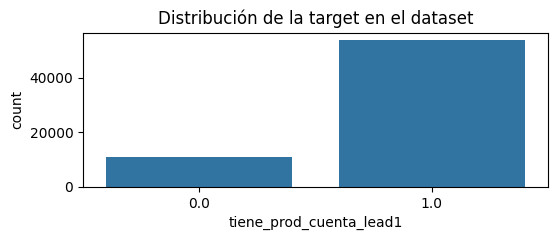

In [76]:
# Crear una figura y un eje para la visualización
fig, ax = plt.subplots(figsize=(6, 2))

# Crear un gráfico de conteo para visualizar la distribución de la variable objetivo (target) en el DataFrame df_train_cuenta
sns.countplot(data=df_train_cuenta, x=target_prod_cuenta)

# Establecer el título del gráfico
plt.title('Distribución de la target en el dataset')

# Mostrar el gráfico
plt.show()

In [77]:
# Contar la frecuencia de los valores en la columna 'tiene_prod_cuenta_lead1' del DataFrame df_train_cuenta
# y normalizar los resultados para obtener el porcentaje de cada valor.
# Esto nos permitirá entender la distribución de la variable objetivo (target) en el dataset de entrenamiento.
df_train_cuenta["tiene_prod_cuenta_lead1"].value_counts(normalize=True)

tiene_prod_cuenta_lead1
1.0    0.83042
0.0    0.16958
Name: proportion, dtype: float64

## 4.2. df_prod_ahorro

In [78]:
# Filtrar el DataFrame df_prod_ahorro para obtener los registros donde el cliente no tiene un producto de ahorro/inversión (tiene_prod_ahorro_inv == 0)
# Luego, agrupar por cliente ('pk_cid') y seleccionar el último registro de cada grupo.
df_prod_ahorro_sinproducto_predecir = (
    df_prod_ahorro[
        (df_prod_ahorro['tiene_prod_ahorro_inv'] == 0)
    ]
    .groupby('pk_cid', as_index=False)
    .last()
)

In [79]:
# Filtrar el DataFrame df_prod_ahorro para obtener los registros donde el cliente no tiene un producto de ahorro/inversión (tiene_prod_ahorro_inv == 0)
# y no tendrá un producto de ahorro/inversión en el siguiente mes (target_prod_ahorro == 0).
# Luego, agrupar por cliente ('pk_cid') y seleccionar el último registro de cada grupo.
df_prod_ahorro_sinproducto = (
    df_prod_ahorro[
        (df_prod_ahorro[target_prod_ahorro] == 0) & 
        (df_prod_ahorro['tiene_prod_ahorro_inv'] == 0)
    ]
    .groupby('pk_cid', as_index=False)
    .last() 
)


In [80]:
df_prod_ahorro

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,days_since_entry,...,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_inv,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
0,1,59,0,0,1,0,0,0,0,0,...,170656.930000,0.000000,0,0,0,1,0,0.0,1,0.000000
1,0,59,0,0,1,0,0,0,0,31,...,176309.679845,3.312347,0,1,0,0,0,NaN,1,5652.749845
2,1,62,1,0,0,0,0,0,0,9,...,141213.851739,0.000000,0,0,0,1,0,0.0,0,0.000000
3,1,62,1,0,0,0,0,0,0,39,...,160980.198311,13.997456,0,1,0,0,0,0.0,0,19766.346572
4,1,62,1,0,0,0,0,0,0,70,...,160980.198311,0.000000,0,1,0,0,0,0.0,0,19766.346572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5953172,0,52,0,1,0,0,0,0,0,-3,...,52673.925000,0.000000,0,0,0,1,0,NaN,0,0.000000
5953173,0,30,0,1,0,0,0,0,0,-3,...,113105.705172,0.000000,0,0,0,1,0,NaN,0,0.000000
5953174,0,21,0,1,0,0,0,0,0,-3,...,170286.024236,0.000000,0,0,0,1,0,NaN,0,0.000000
5953175,0,43,0,1,0,0,0,0,0,-3,...,355549.267500,0.000000,0,0,0,1,0,NaN,0,0.000000


In [81]:
df_prod_ahorro_sinproducto.shape

(432083, 69)

In [82]:
# Filtrar el DataFrame df_prod_ahorro para obtener los registros donde la partición es la máxima (última partición)
# Luego, contar la frecuencia de los valores en la columna 'tiene_prod_ahorro_inv' y normalizar los resultados para obtener el porcentaje de cada valor.
# Esto nos permitirá entender la distribución de la variable objetivo (target) en la última partición del dataset.
df_prod_ahorro[df_prod_ahorro['pk_partition'] == df_prod_ahorro['pk_partition'].max()]['tiene_prod_ahorro_inv'].value_counts(normalize=True)

tiene_prod_ahorro_inv
0    0.94308
1    0.05692
Name: proportion, dtype: float64

In [83]:
# Realizar una muestra aleatoria del DataFrame df_prod_ahorro_sinproducto
# La muestra tendrá un tamaño igual a cuatro veces el tamaño del DataFrame df_prod_ahorro_primera
# El parámetro 'replace' se establece en False para asegurar que no se repitan los registros en la muestra
# El parámetro 'random_state' se establece en 42 para asegurar la reproducibilidad de la muestra
df_prod_ahorro_sinproducto = df_prod_ahorro_sinproducto.sample(len(df_prod_ahorro_primera)*4, replace=False, random_state=42)


In [84]:
# Concatenar los DataFrames df_prod_ahorro_primera y df_prod_ahorro_sinproducto para crear el DataFrame de entrenamiento df_train_ahorro
# df_prod_ahorro_primera contiene los registros donde el cliente tendrá un producto de ahorro/inversión en el siguiente mes y actualmente no tiene un producto de ahorro/inversión
# df_prod_ahorro_sinproducto contiene los registros donde el cliente no tiene un producto de ahorro/inversión y no tendrá un producto de ahorro/inversión en el siguiente mes
df_train_ahorro = pd.concat([df_prod_ahorro_primera, df_prod_ahorro_sinproducto])


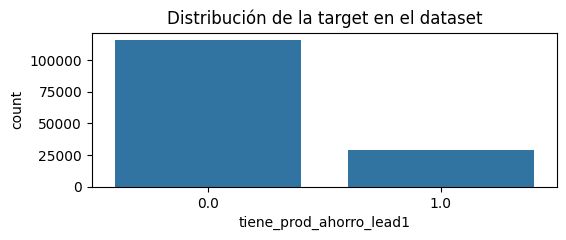

In [85]:
# Crear una figura y un eje para la visualización
fig, ax = plt.subplots(figsize=(6, 2))

# Crear un gráfico de conteo para visualizar la distribución de la variable objetivo (target) en el DataFrame df_train_ahorro
sns.countplot(data=df_train_ahorro, x=target_prod_ahorro)

# Establecer el título del gráfico
plt.title('Distribución de la target en el dataset')

# Mostrar el gráfico
plt.show()

In [86]:
# Contar la frecuencia de los valores en la columna 'tiene_prod_ahorro_lead1' del DataFrame df_train_ahorro
# y normalizar los resultados para obtener el porcentaje de cada valor.
# Esto nos permitirá entender la distribución de la variable objetivo (target) en el dataset de entrenamiento.
df_train_ahorro["tiene_prod_ahorro_lead1"].value_counts(normalize=True)

tiene_prod_ahorro_lead1
0.0    0.8
1.0    0.2
Name: proportion, dtype: float64

## 4.3. df_prod_finan

In [87]:
# Obtener el valor máximo de la columna 'pk_partition' en el DataFrame df_prod_finan
# Esto nos permitirá identificar la última partición (mes) en el dataset
df_prod_finan['pk_partition'].max()

Timestamp('2019-05-28 00:00:00')

In [88]:
# Filtrar el DataFrame df_prod_finan para obtener los registros donde el cliente no tiene un producto de financiación (tiene_prod_financiacion == 0)
# Luego, agrupar por cliente ('pk_cid') y seleccionar el último registro de cada grupo.
df_prod_finan_sinproducto_predecir = (
    df_prod_finan[
        (df_prod_finan['tiene_prod_financiacion'] == 0)
    ]
    .groupby('pk_cid', as_index=False)
    .last()
)

In [89]:
# Obtener el valor máximo de la columna 'pk_partition' en el DataFrame df_prod_finan_sinproducto_predecir
# Esto nos permitirá identificar la última partición (mes) en el dataset de clientes sin productos de financiación
df_prod_finan_sinproducto_predecir['pk_partition'].max()

Timestamp('2019-05-28 00:00:00')

In [90]:
# Filtrar el DataFrame df_prod_finan para obtener los registros donde el cliente no tiene un producto de financiación (tiene_prod_financiacion == 0)
# y no tendrá un producto de financiación en el siguiente mes (target_prod_finan == 0).
# Luego, agrupar por cliente ('pk_cid') y seleccionar el último registro de cada grupo.
df_prod_finan_sinproducto = (
    df_prod_finan[
        (df_prod_finan[target_prod_finan] == 0) & 
        (df_prod_finan['tiene_prod_financiacion'] == 0)
    ]
    .groupby('pk_cid', as_index=False)
    .last() 
)

In [91]:
df_prod_finan

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,debit_card,...,securities,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_finan_lead1,tiene_prod_financiacion,total_sin_tiene_prod_financiacion,variacion_salarial_abs
0,1,59,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0.0,0,1,0.000000
1,0,59,0,0,1,0,0,0,31,0,...,0,0,1,0,0,0,NaN,0,1,5652.749845
2,1,62,1,0,0,0,0,0,9,0,...,0,0,0,0,1,0,0.0,0,0,0.000000
3,1,62,1,0,0,0,0,0,39,0,...,0,0,1,0,0,0,0.0,0,0,19766.346572
4,1,62,1,0,0,0,0,0,70,0,...,0,0,1,0,0,0,0.0,0,0,19766.346572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5953172,0,52,0,1,0,0,0,0,-3,0,...,0,0,0,0,1,0,NaN,0,0,0.000000
5953173,0,30,0,1,0,0,0,0,-3,0,...,0,0,0,0,1,0,NaN,0,0,0.000000
5953174,0,21,0,1,0,0,0,0,-3,0,...,0,0,0,0,1,0,NaN,0,0,0.000000
5953175,0,43,0,1,0,0,0,0,-3,0,...,0,0,0,0,1,0,NaN,0,0,0.000000


In [92]:
df_prod_finan_sinproducto.shape

(443788, 72)

In [93]:
# Ordenar el DataFrame df_prod_finan_sinproducto por la columna 'pk_partition' de forma ascendente
# Esto nos permitirá tener los registros organizados cronológicamente por partición (mes)
df_prod_finan_sinproducto.sort_values(by=['pk_partition'], inplace=True)

In [94]:
# Realizar una muestra aleatoria del DataFrame df_prod_finan_sinproducto
# La muestra tendrá un tamaño igual a cuatro veces el tamaño del DataFrame df_prod_finan_primera
# El parámetro 'replace' se establece en False para asegurar que no se repitan los registros en la muestra
# El parámetro 'random_state' se establece en 42 para asegurar la reproducibilidad de la muestra
df_prod_finan_sinproducto = df_prod_finan_sinproducto.sample(len(df_prod_finan_primera)*4, replace=False, random_state=42)


In [95]:
# Concatenar los DataFrames df_prod_finan_primera y df_prod_finan_sinproducto para crear el DataFrame de entrenamiento df_train_finan
# df_prod_finan_primera contiene los registros donde el cliente tendrá un producto de financiación en el siguiente mes y actualmente no tiene un producto de financiación
# df_prod_finan_sinproducto contiene los registros donde el cliente no tiene un producto de financiación y no tendrá un producto de financiación en el siguiente mes
df_train_finan = pd.concat([df_prod_finan_primera, df_prod_finan_sinproducto])


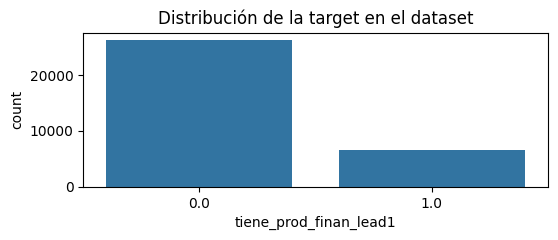

In [96]:
# Crear una figura y un eje para la visualización
fig, ax = plt.subplots(figsize=(6, 2))

# Crear un gráfico de conteo para visualizar la distribución de la variable objetivo (target) en el DataFrame df_train_finan
sns.countplot(data=df_train_finan, x=target_prod_finan)

# Establecer el título del gráfico
plt.title('Distribución de la target en el dataset')

# Mostrar el gráfico
plt.show()

In [97]:
# Contar la frecuencia de los valores en la columna 'tiene_prod_finan_lead1' del DataFrame df_train_finan
# y normalizar los resultados para obtener el porcentaje de cada valor.
# Esto nos permitirá entender la distribución de la variable objetivo (target) en el dataset de entrenamiento.
df_train_finan["tiene_prod_finan_lead1"].value_counts(normalize=True)

tiene_prod_finan_lead1
0.0    0.8
1.0    0.2
Name: proportion, dtype: float64

# 5. Análisis de correlación

## 5.1. df_train_cuenta

### 5.1.1. Correlacion

In [98]:
# Crear una copia del DataFrame df_train_cuenta y asignarla a una nueva variable
# Esto nos permitirá trabajar con una copia del DataFrame original sin modificarlo directamente
df_train_cuenta.copy()

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,securities,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_cuenta,tiene_prod_cuenta_lead1,total_sin_tiene_prod_cuenta,variacion_salarial_abs
0,16502,1,58,1,0,0,0,0,0,89,...,0,0,1,0,0,0,0,1.0,0,45690.165071
1,17457,1,53,0,0,0,0,0,1,346,...,0,0,1,0,0,0,0,1.0,1,0.000000
2,18146,1,65,1,0,0,0,0,0,64,...,0,1,0,0,0,0,0,1.0,0,49392.147829
3,20243,1,75,1,0,0,0,0,0,65,...,0,0,1,0,0,0,0,1.0,0,33444.880150
4,22212,1,53,0,0,0,0,0,1,566,...,0,0,1,0,0,0,0,1.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183123,1263758,1,46,0,0,0,0,0,1,650,...,0,0,1,0,0,0,0,0.0,0,0.000000
52050,1073985,0,23,0,1,0,0,0,0,1303,...,0,0,0,1,0,0,0,0.0,0,0.000000
362354,1491695,0,22,0,0,1,0,0,0,183,...,0,0,0,1,0,0,0,0.0,0,24248.462514
135239,1192005,0,31,0,0,0,1,0,0,932,...,0,0,1,0,0,0,0,0.0,0,0.000000


In [99]:
# Calcular la matriz de correlación para el DataFrame df_train_cuenta
# La función corr() calcula la correlación entre todas las columnas numéricas del DataFrame
# El parámetro numeric_only=True asegura que solo se consideren las columnas numéricas en el cálculo
df_corr_cuenta = df_train_cuenta.corr(numeric_only=True)


In [100]:
df_train_cuenta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64866 entries, 0 to 12677
Data columns (total 66 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   pk_cid                          64866 non-null  int32         
 1   active_customer                 64866 non-null  int16         
 2   age                             64866 non-null  int16         
 3   cluster_0                       64866 non-null  int32         
 4   cluster_1                       64866 non-null  int32         
 5   cluster_2                       64866 non-null  int32         
 6   cluster_3                       64866 non-null  int32         
 7   cluster_4                       64866 non-null  int32         
 8   cluster_5                       64866 non-null  int32         
 9   days_since_entry                64866 non-null  int64         
 10  deceased_N                      64866 non-null  int32         
 11  entry_c

In [101]:
df_corr_cuenta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, pk_cid to variacion_salarial_abs
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pk_cid                          61 non-null     float64
 1   active_customer                 61 non-null     float64
 2   age                             61 non-null     float64
 3   cluster_0                       61 non-null     float64
 4   cluster_1                       61 non-null     float64
 5   cluster_2                       61 non-null     float64
 6   cluster_3                       61 non-null     float64
 7   cluster_4                       61 non-null     float64
 8   cluster_5                       61 non-null     float64
 9   days_since_entry                61 non-null     float64
 10  deceased_N                      0 non-null      float64
 11  entry_channel_KAT               61 non-null     float64
 12  entry_channel_KFC 

In [102]:
# Calcular la matriz de correlación para el DataFrame df_train_cuenta
df_corr_cuenta = df_train_cuenta.corr(numeric_only=True)

# Sacar los pares de variables muy correlacionadas (positiva o negativamente)
# Crear un DataFrame que contenga solo la parte superior del triángulo de la matriz de correlación para evitar que se repitan los valores
df_triangulo = pd.DataFrame(np.triu(df_corr_cuenta, k=1), columns=df_corr_cuenta.columns) 
# np.triu - extrae la parte superior del triángulo de la matriz de correlación
# k=1 - excluye la diagonal principal (k=0 la incluye)
# columns se queda con las columnas del DataFrame df_corr_cuenta

# Cambiar los nombres de las filas (index) de df_triangulo para que coincidan con los nombres de las columnas de df_corr_cuenta
df_triangulo.index = df_corr_cuenta.columns

# Mostrar el DataFrame df_triangulo
df_triangulo

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,securities,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_cuenta,tiene_prod_cuenta_lead1,total_sin_tiene_prod_cuenta,variacion_salarial_abs
pk_cid,0.0,0.038877,0.059336,0.466800,-0.019886,0.106751,-0.205188,-0.136039,-0.298206,-0.731805,...,-0.018899,0.044363,0.050813,-0.235405,0.279537,0.067374,NaN,0.074826,0.011158,0.036837
active_customer,0.0,0.000000,0.150757,0.188922,-0.398104,-0.325960,-0.470470,0.168330,0.333385,-0.183646,...,0.032752,0.088835,0.176812,-0.190772,-0.057307,0.057213,NaN,0.484654,0.129092,-0.005024
age,0.0,0.000000,0.000000,0.153293,-0.058630,-0.030203,-0.146930,0.026009,-0.038692,-0.217208,...,0.038246,0.324234,0.425628,-0.625282,0.058219,0.128997,NaN,0.195815,0.147759,0.006563
cluster_0,0.0,0.000000,0.000000,0.000000,-0.158137,-0.192640,-0.216000,-0.241465,-0.526194,-0.480373,...,-0.012753,0.105679,0.018858,-0.274291,0.353204,0.061265,NaN,0.180448,-0.073164,0.026544
cluster_1,0.0,0.000000,0.000000,0.000000,0.000000,-0.061720,-0.069204,-0.077363,-0.168588,0.120189,...,-0.013544,-0.046065,-0.026963,0.078535,-0.049960,-0.015791,NaN,-0.421590,-0.122533,0.011732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
short_term_deposit,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.057237,0.248893,-0.011288
tiene_prod_cuenta,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN
tiene_prod_cuenta_lead1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.223112,-0.008332
total_sin_tiene_prod_cuenta,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.023340


In [103]:
# Apilar el DataFrame df_triangulo para convertirlo en un formato largo (long format)
# Esto nos permitirá trabajar con pares de variables y sus correlaciones
df_altas_correlaciones = df_triangulo.stack().reset_index()

# Renombrar las columnas del DataFrame resultante para mayor claridad
df_altas_correlaciones.columns = ['variable1', 'variable2', 'correlacion']

# Filtrar el DataFrame para obtener solo las correlaciones absolutas mayores a 0.95
# Esto nos permitirá identificar pares de variables con alta correlación
df_altas_correlaciones = df_altas_correlaciones[df_altas_correlaciones['correlacion'].abs() > 0.95]

# Mostrar el DataFrame resultante con las correlaciones altas
df_altas_correlaciones

,variable1,variable2,correlacion
1011,gender_H,gender_V,-1.0


In [104]:
# Calcular la correlación de todas las variables con la variable objetivo (target) 'tiene_prod_cuenta_lead1'
# La función corr() calcula la correlación entre todas las columnas del DataFrame df_train_cuenta
# Seleccionamos la columna correspondiente a la variable objetivo para obtener las correlaciones específicas con esta variable
corr_con_target = df_train_cuenta.corr()[target_prod_cuenta]

# Imprimir un mensaje indicando que se están obteniendo las correlaciones con la variable objetivo
print("Sacamos las correlaciones de las variables con la target")

# Mostrar las correlaciones de las variables con la variable objetivo
corr_con_target

Sacamos las correlaciones de las variables con la target


pk_cid                         0.074826
active_customer                0.484654
age                            0.195815
cluster_0                      0.180448
cluster_1                     -0.421590
                                 ...   
short_term_deposit             0.057237
tiene_prod_cuenta                   NaN
tiene_prod_cuenta_lead1        1.000000
total_sin_tiene_prod_cuenta    0.223112
variacion_salarial_abs        -0.008332
Name: tiene_prod_cuenta_lead1, Length: 66, dtype: float64

In [105]:
# Añadir la correlación de la variable1 con la variable objetivo (target) al DataFrame df_altas_correlaciones
# Utilizamos la función apply() para aplicar una función lambda a cada valor de la columna 'variable1'
# La función lambda toma el nombre de la variable y obtiene su correlación con la variable objetivo desde el objeto corr_con_target
df_altas_correlaciones['corr_var1_target'] = df_altas_correlaciones['variable1'].apply(lambda x: corr_con_target[x])

# Añadir la correlación de la variable2 con la variable objetivo (target) al DataFrame df_altas_correlaciones
# Utilizamos la función apply() para aplicar una función lambda a cada valor de la columna 'variable2'
# La función lambda toma el nombre de la variable y obtiene su correlación con la variable objetivo desde el objeto corr_con_target
df_altas_correlaciones['corr_var2_target'] = df_altas_correlaciones['variable2'].apply(lambda x: corr_con_target[x])

# Imprimir un mensaje indicando que se han añadido las correlaciones al DataFrame de altas correlaciones
print("Añadimos las correlaciones al DataFrame de altas correlaciones")

# Mostrar el DataFrame df_altas_correlaciones con las nuevas columnas de correlaciones añadidas
df_altas_correlaciones

Añadimos las correlaciones al DataFrame de altas correlaciones


,variable1,variable2,correlacion,corr_var1_target,corr_var2_target
1011,gender_H,gender_V,-1.0,-0.060899,0.060899


In [106]:
# Añadir una nueva columna 'var_menos_corr' al DataFrame df_altas_correlaciones
# Esta columna contendrá la variable del par de variables altamente correlacionadas que tiene menor correlación con la variable objetivo (target)
# Utilizamos la función apply() para aplicar una función lambda a cada fila del DataFrame
# La función lambda compara las correlaciones absolutas de 'variable1' y 'variable2' con la variable objetivo
# Si la correlación absoluta de 'variable1' con la variable objetivo es menor que la de 'variable2', se selecciona 'variable1'
# De lo contrario, se selecciona 'variable2'
df_altas_correlaciones['var_menos_corr'] = df_altas_correlaciones.apply(lambda linea: linea['variable1'] if np.abs(linea['corr_var1_target']) < np.abs(linea['corr_var2_target']) else linea['variable2'], axis=1)

# Imprimir un mensaje indicando que se ha añadido la variable menos correlacionada con la target del par de variables altamente correlacionadas
print("Añadimos la variable menos correlacionada con la target del par de variables altamente correlacionadas")

# Mostrar el DataFrame df_altas_correlaciones con la nueva columna añadida
df_altas_correlaciones

Añadimos la variable menos correlacionada con la target del par de variables altamente correlacionadas


,variable1,variable2,correlacion,corr_var1_target,corr_var2_target,var_menos_corr
1011,gender_H,gender_V,-1.0,-0.060899,0.060899,gender_H


In [107]:
# Obtener la lista de variables menos correlacionadas con la target del par de variables altamente correlacionadas
# Utilizamos la función set() para eliminar duplicados y convertir el resultado en una lista
var_menos_corr = list(set(df_altas_correlaciones['var_menos_corr']))

# Imprimir un mensaje indicando que se eliminarán las variables menos correlacionadas con la target
print("De las variables altamentes correlacionadas entre sí, eliminamos las de menor correlación con la target")

De las variables altamentes correlacionadas entre sí, eliminamos las de menor correlación con la target


In [108]:
var_menos_corr

['gender_H']

In [109]:
# Eliminamos las variables altamente correlacionadas que aportan menos valor del dataset df_train_cuenta
# Utilizamos el método drop() para eliminar las columnas especificadas en la lista var_menos_corr
# El parámetro columns se establece en var_menos_corr para especificar las columnas a eliminar
# El parámetro inplace se establece en True para realizar la operación en el DataFrame original sin crear una copia
df_train_cuenta.drop(columns=var_menos_corr, inplace=True)

# Eliminamos las mismas variables del dataset df_prod_cuenta_sinproducto_predecir
df_prod_cuenta_sinproducto_predecir.drop(columns=var_menos_corr, inplace=True)

# Mostramos la información del DataFrame df_train_cuenta para verificar que las columnas se han eliminado correctamente
df_train_cuenta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64866 entries, 0 to 12677
Data columns (total 65 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   pk_cid                          64866 non-null  int32         
 1   active_customer                 64866 non-null  int16         
 2   age                             64866 non-null  int16         
 3   cluster_0                       64866 non-null  int32         
 4   cluster_1                       64866 non-null  int32         
 5   cluster_2                       64866 non-null  int32         
 6   cluster_3                       64866 non-null  int32         
 7   cluster_4                       64866 non-null  int32         
 8   cluster_5                       64866 non-null  int32         
 9   days_since_entry                64866 non-null  int64         
 10  deceased_N                      64866 non-null  int32         
 11  entry_c

### 5.1.2. Baja varianza

In [110]:
df_train_cuenta['tiene_prod_cuenta'].value_counts()

tiene_prod_cuenta
0    64866
Name: count, dtype: int64

In [111]:
# Inicializar una lista vacía para almacenar las columnas con baja varianza
var_poca_varianza_cuenta = [] 
print('baja varianza:')

# Iterar sobre cada columna del DataFrame df_train_cuenta
for col in df_train_cuenta.columns:
    # Verificar si la columna es de tipo datetime
    if np.issubdtype(df_train_cuenta[col].dtype, np.datetime64):  
        continue  # Si es datetime, no la consideramos para eliminación y pasamos a la siguiente columna
    
    # Calcular la varianza de la columna y verificar si es menor a 0.01
    if df_train_cuenta[col].var() < 0.01:
        # Imprimir el nombre de la columna y su varianza
        print(col, df_train_cuenta[col].var())
        # Añadir la columna a la lista de columnas con baja varianza
        var_poca_varianza_cuenta.append(col)

# Imprimir las columnas que se eliminarán por tener baja varianza
print('eliminar', var_poca_varianza_cuenta)


baja varianza:
deceased_N 0.0
funds 0.003196377476380109
ha_recomprado_prod_ahorro 0.0004006718340508644
ha_recomprado_prod_cuenta 0.0
ha_recomprado_prod_finan 0.0004468825223190343
loans 7.70772310194713e-05
mortgage 3.0832318421529045e-05
region_name_Cáceres 0.008770842013746345
securities 0.0035944786829947423
tiene_prod_cuenta 0.0
eliminar ['deceased_N', 'funds', 'ha_recomprado_prod_ahorro', 'ha_recomprado_prod_cuenta', 'ha_recomprado_prod_finan', 'loans', 'mortgage', 'region_name_Cáceres', 'securities', 'tiene_prod_cuenta']


#### 5.1.2.1. Eliminación de variables con baja varianza

In [112]:
# Eliminar las columnas con baja varianza del DataFrame df_train_cuenta
# Utilizamos el método drop() para eliminar las columnas especificadas en la lista var_poca_varianza_cuenta
# El parámetro columns se establece en var_poca_varianza_cuenta para especificar las columnas a eliminar
# El parámetro inplace se establece en True para realizar la operación en el DataFrame original sin crear una copia
df_train_cuenta.drop(columns=var_poca_varianza_cuenta, inplace=True)

# Eliminar las mismas columnas con baja varianza del DataFrame df_prod_cuenta_sinproducto_predecir
df_prod_cuenta_sinproducto_predecir.drop(columns=var_poca_varianza_cuenta, inplace=True)

# Mostrar el DataFrame df_train_cuenta para verificar que las columnas se han eliminado correctamente
df_train_cuenta

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_cuenta_lead1,total_sin_tiene_prod_cuenta,variacion_salarial_abs
0,16502,1,58,1,0,0,0,0,0,89,...,180256.629898,0.0,0,1,0,0,0,1.0,0,45690.165071
1,17457,1,53,0,0,0,0,0,1,346,...,102405.750000,0.0,0,1,0,0,0,1.0,1,0.000000
2,18146,1,65,1,0,0,0,0,0,64,...,175951.518283,0.0,1,0,0,0,0,1.0,0,49392.147829
3,20243,1,75,1,0,0,0,0,0,65,...,144736.162150,0.0,0,1,0,0,0,1.0,0,33444.880150
4,22212,1,53,0,0,0,0,0,1,566,...,168943.230000,0.0,0,1,0,0,0,1.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183123,1263758,1,46,0,0,0,0,0,1,650,...,80434.500000,0.0,0,1,0,0,0,0.0,0,0.000000
52050,1073985,0,23,0,1,0,0,0,0,1303,...,465699.720000,0.0,0,0,1,0,0,0.0,0,0.000000
362354,1491695,0,22,0,0,1,0,0,0,183,...,194534.486750,0.0,0,0,1,0,0,0.0,0,24248.462514
135239,1192005,0,31,0,0,0,1,0,0,932,...,79113.570000,0.0,0,1,0,0,0,0.0,0,0.000000


## 5.2. df_train_ahorro

### 5.2.1. Correlación

In [113]:
df_train_ahorro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144770 entries, 0 to 197651
Data columns (total 69 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   pk_cid                           144770 non-null  int32         
 1   active_customer                  144770 non-null  int16         
 2   age                              144770 non-null  int16         
 3   cluster_0                        144770 non-null  int32         
 4   cluster_1                        144770 non-null  int32         
 5   cluster_2                        144770 non-null  int32         
 6   cluster_3                        144770 non-null  int32         
 7   cluster_4                        144770 non-null  int32         
 8   cluster_5                        144770 non-null  int32         
 9   credit_card                      144770 non-null  int16         
 10  days_since_entry                 144770 non-null 

In [114]:
# Eliminar las columnas en las posiciones 15 y 25 del DataFrame df_train_ahorro
# Utilizamos el método drop() para eliminar las columnas especificadas por sus índices
# El parámetro axis=1 indica que estamos eliminando columnas
df_sin_datetime = df_train_ahorro.drop(df_train_ahorro.columns[[15, 25]], axis=1)


In [115]:
df_sin_datetime

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,...,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_inv,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
0,17457,1,53,0,0,0,0,0,1,0,...,102405.750000,0.0,0,1,0,0,0,1.0,2,0.000000
1,28191,0,81,1,0,0,0,0,0,0,...,80161.620000,0.0,0,1,0,0,0,1.0,0,0.000000
2,33205,1,64,1,0,0,0,0,0,0,...,112952.168691,0.0,0,0,0,1,0,1.0,3,0.000000
3,33620,1,50,0,0,0,0,1,0,0,...,138618.570000,0.0,0,1,0,0,0,1.0,1,0.000000
4,35063,1,62,1,0,0,0,0,0,0,...,125530.410000,0.0,1,0,0,0,0,1.0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61395,1076948,0,30,0,0,0,1,0,0,0,...,82381.500000,0.0,0,0,1,0,0,0.0,1,0.000000
166161,1211595,0,32,0,1,0,0,0,0,0,...,93168.810000,0.0,0,0,1,0,0,0.0,2,0.000000
165733,1211093,0,22,1,0,0,0,0,0,0,...,99855.540000,0.0,0,0,1,0,0,0.0,2,0.000000
334460,1429365,0,29,0,1,0,0,0,0,0,...,74029.074283,0.0,0,1,0,0,0,0.0,0,14925.271342


In [116]:
# Filtramos solo las columnas numéricas antes de calcular la correlación
df_numeric = df_train_ahorro.select_dtypes(include=[np.number])  

# Calculamos la matriz de correlaciones solo con datos numéricos
df_corr_ahorro = df_numeric.corr()

# Creamos el dataframe del triángulo superior
df_triangulo = pd.DataFrame(np.triu(df_corr_ahorro, k=1), columns=df_corr_ahorro.columns) 

# Asignamos los índices correctamente
df_triangulo.index = df_numeric.columns  

df_triangulo


,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,...,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_inv,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
pk_cid,0.0,0.011659,-0.067100,0.352576,0.065542,0.292982,-0.289027,-0.170065,-0.151305,-0.092820,...,-0.010291,0.038941,0.018859,-0.010164,-0.063292,0.191748,NaN,-0.001124,-0.056686,0.055215
active_customer,0.0,0.000000,0.249838,0.347640,-0.443995,-0.238060,-0.485013,0.382721,0.483641,0.122712,...,-0.001004,0.013636,0.119788,0.295049,-0.324866,0.013098,NaN,0.419349,0.573201,-0.018928
age,0.0,0.000000,0.000000,0.116801,-0.026710,-0.110377,-0.211353,0.070446,0.166924,0.089969,...,0.002452,0.022993,0.223391,0.609351,-0.701827,0.131577,NaN,0.248557,0.194262,-0.022674
cluster_0,0.0,0.000000,0.000000,0.000000,-0.206640,-0.140692,-0.239131,-0.171762,-0.210139,-0.031599,...,0.001486,0.047409,0.075607,0.099869,-0.203021,0.239879,NaN,0.085773,0.093024,0.017408
cluster_1,0.0,0.000000,0.000000,0.000000,0.000000,-0.155291,-0.263944,-0.189585,-0.231944,-0.055476,...,0.044292,0.003904,-0.055730,0.033999,-0.013311,-0.014822,NaN,-0.230397,-0.527541,0.030219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
segment_Desconocido,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.184920,0.078372,-0.008334
tiene_prod_ahorro_inv,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN
tiene_prod_ahorro_lead1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.671384,-0.024196
total_sin_tiene_prod_ahorro_inv,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.029421


In [118]:
# Apilar el DataFrame df_triangulo para convertirlo en un formato largo (long format)
# Esto nos permitirá trabajar con pares de variables y sus correlaciones
df_altas_correlaciones = df_triangulo.stack().reset_index()

# Renombrar las columnas del DataFrame resultante para mayor claridad
df_altas_correlaciones.columns = ['variable1', 'variable2', 'correlacion']

# Filtrar el DataFrame para obtener solo las correlaciones absolutas mayores a 0.95
# Esto nos permitirá identificar pares de variables con alta correlación
df_altas_correlaciones = df_altas_correlaciones[df_altas_correlaciones['correlacion'].abs() > 0.95]

# Mostrar el DataFrame resultante con las correlaciones altas
df_altas_correlaciones

,variable1,variable2,correlacion
1241,gender_H,gender_V,-1.0


In [119]:
# Calcular la correlación de todas las variables con la variable objetivo (target) 'tiene_prod_ahorro_lead1'
# La función corr() calcula la correlación entre todas las columnas del DataFrame df_train_ahorro
# Seleccionamos la columna correspondiente a la variable objetivo para obtener las correlaciones específicas con esta variable
corr_con_target = df_train_ahorro.corr()[target_prod_ahorro]

# Imprimir un mensaje indicando que se están obteniendo las correlaciones con la variable objetivo
print("Sacamos las correlaciones de las variables con la target")

# Mostrar las correlaciones de las variables con la variable objetivo
corr_con_target

Sacamos las correlaciones de las variables con la target


pk_cid                            -0.001124
active_customer                    0.419349
age                                0.248557
cluster_0                          0.085773
cluster_1                         -0.230397
                                     ...   
segment_Desconocido                0.184920
tiene_prod_ahorro_inv                   NaN
tiene_prod_ahorro_lead1            1.000000
total_sin_tiene_prod_ahorro_inv    0.671384
variacion_salarial_abs            -0.024196
Name: tiene_prod_ahorro_lead1, Length: 69, dtype: float64

In [120]:
# Añadir la correlación de la variable1 con la variable objetivo (target) al DataFrame df_altas_correlaciones
# Utilizamos la función apply() para aplicar una función lambda a cada valor de la columna 'variable1'
# La función lambda toma el nombre de la variable y obtiene su correlación con la variable objetivo desde el objeto corr_con_target
df_altas_correlaciones['corr_var1_target'] = df_altas_correlaciones['variable1'].apply(lambda x: corr_con_target[x])

# Añadir la correlación de la variable2 con la variable objetivo (target) al DataFrame df_altas_correlaciones
# Utilizamos la función apply() para aplicar una función lambda a cada valor de la columna 'variable2'
# La función lambda toma el nombre de la variable y obtiene su correlación con la variable objetivo desde el objeto corr_con_target
df_altas_correlaciones['corr_var2_target'] = df_altas_correlaciones['variable2'].apply(lambda x: corr_con_target[x])

# Imprimir un mensaje indicando que se han añadido las correlaciones al DataFrame de altas correlaciones
print("Añadimos las correlaciones al DataFrame de altas correlaciones")

# Mostrar el DataFrame df_altas_correlaciones con las nuevas columnas de correlaciones añadidas
df_altas_correlaciones

Añadimos las correlaciones al DataFrame de altas correlaciones


,variable1,variable2,correlacion,corr_var1_target,corr_var2_target
1241,gender_H,gender_V,-1.0,-0.04566,0.04566


In [121]:
# Añadir una nueva columna 'var_menos_corr' al DataFrame df_altas_correlaciones
# Esta columna contendrá la variable del par de variables altamente correlacionadas que tiene menor correlación con la variable objetivo (target)
# Utilizamos la función apply() para aplicar una función lambda a cada fila del DataFrame
# La función lambda compara las correlaciones absolutas de 'variable1' y 'variable2' con la variable objetivo
# Si la correlación absoluta de 'variable1' con la variable objetivo es menor que la de 'variable2', se selecciona 'variable1'
# De lo contrario, se selecciona 'variable2'
df_altas_correlaciones['var_menos_corr'] = df_altas_correlaciones.apply(lambda linea: linea['variable1'] if np.abs(linea['corr_var1_target']) < np.abs(linea['corr_var2_target']) else linea['variable2'], axis=1)

# Imprimir un mensaje indicando que se ha añadido la variable menos correlacionada con la target del par de variables altamente correlacionadas
print("Añadimos la variable menos correlacionada con la target del par de variables altamente correlacionadas")

# Mostrar el DataFrame df_altas_correlaciones con la nueva columna añadida
df_altas_correlaciones

Añadimos la variable menos correlacionada con la target del par de variables altamente correlacionadas


,variable1,variable2,correlacion,corr_var1_target,corr_var2_target,var_menos_corr
1241,gender_H,gender_V,-1.0,-0.04566,0.04566,gender_H


In [122]:
# Vemos que hay grupos de 3 variables altamente correlacionadas (max, min, med)
# Eliminamos las 2 menos correlacionadas con la target, quedándonos con la que aporta más valor al modelo

# Obtener la lista de variables menos correlacionadas con la target del par de variables altamente correlacionadas
# Utilizamos la función set() para eliminar duplicados y convertir el resultado en una lista
var_menos_corr = list(set(df_altas_correlaciones['var_menos_corr']))

# Mostrar la lista de variables menos correlacionadas con la target
var_menos_corr

['gender_H']

In [123]:
# Eliminamos las variables altamente correlacionadas que aportan menos valor del dataset df_train_ahorro
# Utilizamos el método drop() para eliminar las columnas especificadas en la lista var_menos_corr
# El parámetro columns se establece en var_menos_corr para especificar las columnas a eliminar
# El parámetro inplace se establece en True para realizar la operación en el DataFrame original sin crear una copia
df_train_ahorro.drop(columns=var_menos_corr, inplace=True)

# Eliminamos las mismas variables del dataset df_prod_ahorro_sinproducto_predecir
df_prod_ahorro_sinproducto_predecir.drop(columns=var_menos_corr, inplace=True)

# Mostramos la información del DataFrame df_train_ahorro para verificar que las columnas se han eliminado correctamente
df_train_ahorro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144770 entries, 0 to 197651
Data columns (total 68 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   pk_cid                           144770 non-null  int32         
 1   active_customer                  144770 non-null  int16         
 2   age                              144770 non-null  int16         
 3   cluster_0                        144770 non-null  int32         
 4   cluster_1                        144770 non-null  int32         
 5   cluster_2                        144770 non-null  int32         
 6   cluster_3                        144770 non-null  int32         
 7   cluster_4                        144770 non-null  int32         
 8   cluster_5                        144770 non-null  int32         
 9   credit_card                      144770 non-null  int16         
 10  days_since_entry                 144770 non-null 

### 5.2.2. Baja varianza

In [124]:
# Inicializar una lista vacía para almacenar las columnas con baja varianza
var_poca_varianza_ahorro = []
print('baja varianza:')

# Filtrar solo columnas numéricas antes de calcular la varianza
df_numeric = df_train_ahorro.select_dtypes(include=[np.number])

# Iterar sobre cada columna numérica del DataFrame df_train_ahorro
for col in df_numeric.columns:
    # Calcular la varianza de la columna y verificar si es menor a 0.01
    if df_numeric[col].var() < 0.01:
        # Imprimir el nombre de la columna y su varianza
        print(col, df_numeric[col].var())
        # Añadir la columna a la lista de columnas con baja varianza
        var_poca_varianza_ahorro.append(col)
        
# Imprimir las columnas que se eliminarán por tener baja varianza
print('eliminar', var_poca_varianza_ahorro)


baja varianza:
deceased_N 0.0


em_account_p 6.907508461697877e-06
em_account_pp 0.0
ha_recomprado_prod_ahorro 0.0
ha_recomprado_prod_cuenta 0.006041699710899854
ha_recomprado_prod_finan 0.0010005924585691193
loans 8.979016661764593e-05
mortgage 6.216414074708395e-05
payroll 0.0
region_name_Ciudad Real 0.009908868530737316
tiene_prod_ahorro_inv 0.0
eliminar ['deceased_N', 'em_account_p', 'em_account_pp', 'ha_recomprado_prod_ahorro', 'ha_recomprado_prod_cuenta', 'ha_recomprado_prod_finan', 'loans', 'mortgage', 'payroll', 'region_name_Ciudad Real', 'tiene_prod_ahorro_inv']


#### 5.2.2.1 Eliminación de las variables con baja varianza

In [126]:
# Eliminar las columnas con baja varianza del DataFrame df_train_ahorro
# Utilizamos el método drop() para eliminar las columnas especificadas en la lista var_poca_varianza_ahorro
# El parámetro columns se establece en var_poca_varianza_ahorro para especificar las columnas a eliminar
# El parámetro inplace se establece en True para realizar la operación en el DataFrame original sin crear una copia
df_train_ahorro.drop(columns= var_poca_varianza_ahorro, inplace = True)

# Eliminar las mismas columnas con baja varianza del DataFrame df_prod_ahorro_sinproducto_predecir
df_prod_ahorro_sinproducto_predecir.drop(columns= var_poca_varianza_ahorro, inplace = True)

# Mostrar el DataFrame df_train_ahorro para verificar que las columnas se han eliminado correctamente
df_train_ahorro

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,...,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
0,17457,1,53,0,0,0,0,0,1,0,...,0,102405.750000,0.0,0,1,0,0,1.0,2,0.000000
1,28191,0,81,1,0,0,0,0,0,0,...,0,80161.620000,0.0,0,1,0,0,1.0,0,0.000000
2,33205,1,64,1,0,0,0,0,0,0,...,0,112952.168691,0.0,0,0,0,1,1.0,3,0.000000
3,33620,1,50,0,0,0,0,1,0,0,...,0,138618.570000,0.0,0,1,0,0,1.0,1,0.000000
4,35063,1,62,1,0,0,0,0,0,0,...,0,125530.410000,0.0,1,0,0,0,1.0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61395,1076948,0,30,0,0,0,1,0,0,0,...,0,82381.500000,0.0,0,0,1,0,0.0,1,0.000000
166161,1211595,0,32,0,1,0,0,0,0,0,...,0,93168.810000,0.0,0,0,1,0,0.0,2,0.000000
165733,1211093,0,22,1,0,0,0,0,0,0,...,0,99855.540000,0.0,0,0,1,0,0.0,2,0.000000
334460,1429365,0,29,0,1,0,0,0,0,0,...,0,74029.074283,0.0,0,1,0,0,0.0,0,14925.271342


## 5.3. df_train_finan

### 5.3.1. Correlacion

In [127]:
# Asegurarse de que se calculan las correlaciones solo para las columnas numéricas
df_corr_finan = df_train_finan.select_dtypes(include=[np.number]).corr()

# Sacar los pares de variables muy correlacionadas (positiva o negativamente)
# Crear un DataFrame que contenga solo la parte superior del triángulo de la matriz de correlación para evitar que se repitan los valores
df_triangulo = pd.DataFrame(np.triu(df_corr_finan, k=1), columns=df_corr_finan.columns)  
# np.triu - extrae la parte superior del triángulo de la matriz de correlación
# k=1 - excluye la diagonal principal (k=0 la incluye)
# columns se queda con las columnas del DataFrame df_corr_finan

# Cambiar los nombres de las filas (index) de df_triangulo para que coincidan con los nombres de las columnas de df_corr_finan
df_triangulo.index = df_corr_finan.columns

# Mostrar el DataFrame df_triangulo
df_triangulo


,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,securities,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_finan_lead1,tiene_prod_financiacion,total_sin_tiene_prod_financiacion,variacion_salarial_abs
pk_cid,0.0,-0.058698,-0.179459,0.301747,0.110145,0.273017,-0.201154,-0.132152,-0.224708,-0.758704,...,-0.043154,-0.033408,-0.084213,0.063798,0.124610,0.020868,-0.224948,NaN,-0.146358,0.038970
active_customer,0.0,0.000000,0.336192,0.329689,-0.459933,-0.252890,-0.510060,0.355135,0.538165,-0.091027,...,0.092027,0.155532,0.358072,-0.398999,-0.020957,0.038123,0.456586,NaN,0.593749,-0.020038
age,0.0,0.000000,0.000000,0.063775,-0.080183,-0.133004,-0.245955,0.045831,0.318185,-0.011872,...,0.083787,0.260609,0.631515,-0.727082,0.077803,0.037133,0.352873,NaN,0.316736,-0.026654
cluster_0,0.0,0.000000,0.000000,0.000000,-0.186422,-0.125583,-0.216857,-0.158528,-0.219153,-0.392357,...,-0.012197,0.062844,0.100820,-0.143274,0.096245,0.012898,-0.043055,NaN,-0.000550,0.008767
cluster_1,0.0,0.000000,0.000000,0.000000,0.000000,-0.146353,-0.252722,-0.184746,-0.255398,-0.048087,...,-0.042619,-0.076620,-0.014030,0.028165,0.043325,-0.017655,-0.228475,NaN,-0.470926,0.026454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
short_term_deposit,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067697,NaN,0.069128,-0.000470
tiene_prod_finan_lead1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.594223,-0.020259
tiene_prod_financiacion,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN
total_sin_tiene_prod_financiacion,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.030107


In [129]:
# Apilar el DataFrame df_triangulo para convertirlo en un formato largo (long format)
# Esto nos permitirá trabajar con pares de variables y sus correlaciones
df_altas_correlaciones = df_triangulo.stack().reset_index()

# Renombrar las columnas del DataFrame resultante para mayor claridad
df_altas_correlaciones.columns = ['variable1', 'variable2', 'correlacion']

# Filtrar el DataFrame para obtener solo las correlaciones absolutas mayores a 0.95
# Esto nos permitirá identificar pares de variables con alta correlación
df_altas_correlaciones = df_altas_correlaciones[df_altas_correlaciones['correlacion'].abs() > 0.95]

# Mostrar el DataFrame resultante con las correlaciones altas
df_altas_correlaciones

,variable1,variable2,correlacion
1386,gender_H,gender_V,-1.000000
1761,payroll,pension_plan,0.973187


In [130]:
# Calcular la correlación de todas las variables con la variable objetivo (target) 'tiene_prod_finan_lead1'
# La función corr() calcula la correlación entre todas las columnas del DataFrame df_train_finan
# Seleccionamos la columna correspondiente a la variable objetivo para obtener las correlaciones específicas con esta variable
corr_con_target = df_train_finan.corr()[target_prod_finan]

# Imprimir un mensaje indicando que se están obteniendo las correlaciones con la variable objetivo
print("Sacamos las correlaciones de las variables con la target")

# Mostrar las correlaciones de las variables con la variable objetivo
corr_con_target

Sacamos las correlaciones de las variables con la target


pk_cid                              -0.224948
active_customer                      0.456586
age                                  0.352873
cluster_0                           -0.043055
cluster_1                           -0.228475
                                       ...   
short_term_deposit                   0.067697
tiene_prod_finan_lead1               1.000000
tiene_prod_financiacion                   NaN
total_sin_tiene_prod_financiacion    0.594223
variacion_salarial_abs              -0.020259
Name: tiene_prod_finan_lead1, Length: 72, dtype: float64

In [131]:
# Añadir la correlación de la variable1 con la variable objetivo (target) al DataFrame df_altas_correlaciones
# Utilizamos la función apply() para aplicar una función lambda a cada valor de la columna 'variable1'
# La función lambda toma el nombre de la variable y obtiene su correlación con la variable objetivo desde el objeto corr_con_target
df_altas_correlaciones['corr_var1_target'] = df_altas_correlaciones['variable1'].apply(lambda x: corr_con_target[x])

# Añadir la correlación de la variable2 con la variable objetivo (target) al DataFrame df_altas_correlaciones
# Utilizamos la función apply() para aplicar una función lambda a cada valor de la columna 'variable2'
# La función lambda toma el nombre de la variable y obtiene su correlación con la variable objetivo desde el objeto corr_con_target
df_altas_correlaciones['corr_var2_target'] = df_altas_correlaciones['variable2'].apply(lambda x: corr_con_target[x])

# Imprimir un mensaje indicando que se han añadido las correlaciones al DataFrame de altas correlaciones
print("Añadimos las correlaciones al DataFrame de altas correlaciones")

# Mostrar el DataFrame df_altas_correlaciones con las nuevas columnas de correlaciones añadidas
df_altas_correlaciones

Añadimos las correlaciones al DataFrame de altas correlaciones


,variable1,variable2,correlacion,corr_var1_target,corr_var2_target
1386,gender_H,gender_V,-1.000000,-0.108797,0.108797
1761,payroll,pension_plan,0.973187,0.427875,0.438234


In [132]:
# Añadir una nueva columna 'var_menos_corr' al DataFrame df_altas_correlaciones
# Esta columna contendrá la variable del par de variables altamente correlacionadas que tiene menor correlación con la variable objetivo (target)
# Utilizamos la función apply() para aplicar una función lambda a cada fila del DataFrame
# La función lambda compara las correlaciones absolutas de 'variable1' y 'variable2' con la variable objetivo
# Si la correlación absoluta de 'variable1' con la variable objetivo es menor que la de 'variable2', se selecciona 'variable1'
# De lo contrario, se selecciona 'variable2'
df_altas_correlaciones['var_menos_corr'] = df_altas_correlaciones.apply(lambda linea: linea['variable1'] if np.abs(linea['corr_var1_target']) < np.abs(linea['corr_var2_target']) else linea['variable2'], axis=1)

# Imprimir un mensaje indicando que se ha añadido la variable menos correlacionada con la target del par de variables altamente correlacionadas
print("Añadimos la variable menos correlacionada con la target del par de variables altamente correlacionadas")

# Mostrar el DataFrame df_altas_correlaciones con la nueva columna añadida
df_altas_correlaciones

Añadimos la variable menos correlacionada con la target del par de variables altamente correlacionadas


,variable1,variable2,correlacion,corr_var1_target,corr_var2_target,var_menos_corr
1386,gender_H,gender_V,-1.000000,-0.108797,0.108797,gender_H
1761,payroll,pension_plan,0.973187,0.427875,0.438234,payroll


In [133]:
# Vemos que hay grupos de 3 variables altamente correlacionadas (max, min, med)
# Eliminamos las 2 menos correlacionadas con la target, quedándonos con la que aporta más valor al modelo

# Obtener la lista de variables menos correlacionadas con la target del par de variables altamente correlacionadas
# Utilizamos la función set() para eliminar duplicados y convertir el resultado en una lista
var_menos_corr = list(set(df_altas_correlaciones['var_menos_corr']))

# Mostrar la lista de variables menos correlacionadas con la target
var_menos_corr

['payroll', 'gender_H']

In [134]:
# Eliminamos las variables altamente correlacionadas que aportan menos valor del dataset df_train_finan
# Utilizamos el método drop() para eliminar las columnas especificadas en la lista var_menos_corr
# El parámetro columns se establece en var_menos_corr para especificar las columnas a eliminar
# El parámetro inplace se establece en True para realizar la operación en el DataFrame original sin crear una copia
df_train_finan.drop(columns=var_menos_corr, inplace=True)

# Eliminamos las mismas variables del dataset df_prod_finan_sinproducto_predecir
df_prod_finan_sinproducto_predecir.drop(columns=var_menos_corr, inplace=True)

# Mostramos la información del DataFrame df_train_finan para verificar que las columnas se han eliminado correctamente
df_train_finan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32805 entries, 0 to 289036
Data columns (total 70 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   pk_cid                             32805 non-null  int32         
 1   active_customer                    32805 non-null  int16         
 2   age                                32805 non-null  int16         
 3   cluster_0                          32805 non-null  int32         
 4   cluster_1                          32805 non-null  int32         
 5   cluster_2                          32805 non-null  int32         
 6   cluster_3                          32805 non-null  int32         
 7   cluster_4                          32805 non-null  int32         
 8   cluster_5                          32805 non-null  int32         
 9   days_since_entry                   32805 non-null  int64         
 10  debit_card                         328

### 5.3.2. Baja varianza

In [135]:
# Inicializar una lista vacía para almacenar las columnas con baja varianza
var_poca_varianza_finan = []
print('baja varianza:')

# Seleccionar solo las columnas numéricas del DataFrame df_train_finan
numerical_cols = df_train_finan.select_dtypes(include=[np.number]).columns

# Iterar sobre cada columna numérica para calcular su varianza
for col in numerical_cols:
    col_variance = df_train_finan[col].var()
    # Verificar si la varianza de la columna es menor a 0.01
    if col_variance < 0.01:
        # Imprimir el nombre de la columna y su varianza
        print(col, col_variance)
        # Añadir la columna a la lista de columnas con baja varianza
        var_poca_varianza_finan.append(col)

# Imprimir las columnas que se eliminarán por tener baja varianza
print('eliminar', var_poca_varianza_finan)


baja varianza:
deceased_N 0.0
em_account_p 6.0964457607845986e-05
em_account_pp 0.0
funds 0.006751740733845698
ha_recomprado_prod_ahorro 0.005818688844697417
ha_recomprado_prod_cuenta 0.005788560660620326
ha_recomprado_prod_finan 0.0
region_name_Albacete 0.00974941234615479
region_name_Ciudad Real 0.009510282546091188
securities 0.008222922022754722
short_term_deposit 0.0014306993873873953
tiene_prod_financiacion 0.0
eliminar ['deceased_N', 'em_account_p', 'em_account_pp', 'funds', 'ha_recomprado_prod_ahorro', 'ha_recomprado_prod_cuenta', 'ha_recomprado_prod_finan', 'region_name_Albacete', 'region_name_Ciudad Real', 'securities', 'short_term_deposit', 'tiene_prod_financiacion']


#### 5.3.2.1. Eliminación de variables con baja varianza

In [137]:
# Eliminar las columnas con baja varianza del DataFrame df_train_finan
# Utilizamos el método drop() para eliminar las columnas especificadas en la lista var_poca_varianza_finan
# El parámetro columns se establece en var_poca_varianza_finan para especificar las columnas a eliminar
# El parámetro inplace se establece en True para realizar la operación en el DataFrame original sin crear una copia
df_train_finan.drop(columns= var_poca_varianza_finan, inplace = True)

# Eliminar las mismas columnas con baja varianza del DataFrame df_prod_finan_sinproducto_predecir
df_prod_finan_sinproducto_predecir.drop(columns= var_poca_varianza_finan, inplace = True)

# Mostrar el DataFrame df_train_finan para verificar que las columnas se han eliminado correctamente
df_train_finan

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_finan_lead1,total_sin_tiene_prod_financiacion,variacion_salarial_abs
0,19021,0,64,1,0,0,0,0,0,929,...,0,129492.360000,0.0,0,1,0,0,1.0,0,0.0
1,20333,1,48,0,0,0,0,0,1,619,...,0,136112.970000,0.0,0,1,0,0,1.0,2,0.0
2,29008,1,50,0,0,0,0,1,0,12,...,0,82571.520000,0.0,0,1,0,0,1.0,1,0.0
3,29896,0,56,0,0,1,0,0,0,747,...,0,381217.170000,0.0,0,1,0,0,1.0,0,0.0
4,31825,1,67,1,0,0,0,0,0,867,...,0,69794.130000,0.0,1,0,0,0,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125179,1158624,1,22,0,0,0,0,1,0,994,...,0,169219.443863,0.0,0,0,1,0,0.0,1,0.0
276105,1344090,0,21,0,1,0,0,0,0,546,...,0,35560.800000,0.0,0,0,1,0,0.0,0,0.0
341593,1426539,0,20,0,0,1,0,0,0,268,...,0,186142.170000,0.0,0,0,1,0,0.0,1,0.0
275747,1343709,1,41,0,0,0,0,1,0,546,...,0,29314.770000,0.0,0,1,0,0,0.0,1,0.0


In [138]:
# Contar la frecuencia de los valores en la columna 'tiene_prod_cuenta_lead1' del DataFrame df_train_cuenta
# El parámetro dropna=False asegura que los valores NaN también se incluyan en el conteo
df_train_cuenta['tiene_prod_cuenta_lead1'].value_counts(dropna=False)

tiene_prod_cuenta_lead1
1.0    53866
0.0    11000
Name: count, dtype: int64

# 6. Datasets a predecir

## 6.1. df_pred_cuenta

In [139]:
# Filtrar el DataFrame df_prod_cuenta_sinproducto_predecir para obtener los registros donde la partición es la máxima (última partición)
# Esto nos permitirá identificar los clientes sin productos de cuenta en la última partición del dataset
df_pred_cuenta = df_prod_cuenta_sinproducto_predecir[df_prod_cuenta_sinproducto_predecir['pk_partition'] == df_prod_cuenta_sinproducto_predecir['pk_partition'].max()]

# Reiniciar el índice del DataFrame df_pred_cuenta y eliminar el índice anterior
# Esto nos permitirá trabajar con un DataFrame limpio y ordenado
df_pred_cuenta.reset_index(drop=True, inplace=True)

In [140]:
# Filtrar el DataFrame df_train_cuenta para obtener los registros donde el cliente tiene el identificador 'pk_cid' igual a 18146
# Esto nos permitirá analizar los datos específicos de este cliente en el DataFrame de entrenamiento
df_train_cuenta[df_train_cuenta['pk_cid'] == 18146]

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_cuenta_lead1,total_sin_tiene_prod_cuenta,variacion_salarial_abs
2,18146,1,65,1,0,0,0,0,0,64,...,175951.518283,0.0,1,0,0,0,0,1.0,0,49392.147829


In [141]:
df_pred_cuenta

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_cuenta_lead1,total_sin_tiene_prod_cuenta,variacion_salarial_abs
0,16063,0,62,1,0,0,0,0,0,190,...,160980.198311,0.0,0,1,0,0,0,0.0,0,19766.346572
1,16203,1,70,1,0,0,0,0,0,156,...,152841.136667,0.0,1,0,0,0,0,0.0,0,-101780.208333
2,17590,1,55,1,0,0,0,0,0,891,...,407281.110000,0.0,0,1,0,0,0,0.0,0,0.000000
3,17799,1,47,0,0,0,0,1,0,509,...,84511.860000,0.0,0,1,0,0,0,0.0,0,0.000000
4,17980,1,78,0,0,0,0,1,0,389,...,282461.790000,0.0,1,0,0,0,0,0.0,2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370399,1553685,0,52,0,1,0,0,0,0,-3,...,52673.925000,0.0,0,0,0,1,0,NaN,0,0.000000
370400,1553686,0,30,0,1,0,0,0,0,-3,...,113105.705172,0.0,0,0,0,1,0,NaN,0,0.000000
370401,1553687,0,21,0,1,0,0,0,0,-3,...,170286.024236,0.0,0,0,0,1,0,NaN,0,0.000000
370402,1553688,0,43,0,1,0,0,0,0,-3,...,355549.267500,0.0,0,0,0,1,0,NaN,0,0.000000


In [142]:
# Lista de columnas con baja varianza en el DataFrame df_train_cuenta
# Estas columnas fueron identificadas previamente como aquellas cuya varianza es menor a 0.01
var_poca_varianza_cuenta

['deceased_N',
 'funds',
 'ha_recomprado_prod_ahorro',
 'ha_recomprado_prod_cuenta',
 'ha_recomprado_prod_finan',
 'loans',
 'mortgage',
 'region_name_Cáceres',
 'securities',
 'tiene_prod_cuenta']

In [143]:
df_pred_cuenta

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_cuenta_lead1,total_sin_tiene_prod_cuenta,variacion_salarial_abs
0,16063,0,62,1,0,0,0,0,0,190,...,160980.198311,0.0,0,1,0,0,0,0.0,0,19766.346572
1,16203,1,70,1,0,0,0,0,0,156,...,152841.136667,0.0,1,0,0,0,0,0.0,0,-101780.208333
2,17590,1,55,1,0,0,0,0,0,891,...,407281.110000,0.0,0,1,0,0,0,0.0,0,0.000000
3,17799,1,47,0,0,0,0,1,0,509,...,84511.860000,0.0,0,1,0,0,0,0.0,0,0.000000
4,17980,1,78,0,0,0,0,1,0,389,...,282461.790000,0.0,1,0,0,0,0,0.0,2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370399,1553685,0,52,0,1,0,0,0,0,-3,...,52673.925000,0.0,0,0,0,1,0,NaN,0,0.000000
370400,1553686,0,30,0,1,0,0,0,0,-3,...,113105.705172,0.0,0,0,0,1,0,NaN,0,0.000000
370401,1553687,0,21,0,1,0,0,0,0,-3,...,170286.024236,0.0,0,0,0,1,0,NaN,0,0.000000
370402,1553688,0,43,0,1,0,0,0,0,-3,...,355549.267500,0.0,0,0,0,1,0,NaN,0,0.000000


In [144]:
# Seleccionar las columnas 'pk_cid' y 'pk_partition' del DataFrame df_pred_cuenta y asignarlas a df_ids_predecir_cuenta
# Esto nos permitirá guardar los identificadores de los clientes y las particiones para futuras predicciones
df_ids_predecir_cuenta = df_pred_cuenta[['pk_cid', 'pk_partition']]

# Guardar el DataFrame df_ids_predecir_cuenta en un archivo pickle
# Esto nos permitirá cargar los datos de identificadores de clientes y particiones en el futuro sin necesidad de recalcularlos
df_ids_predecir_cuenta.to_pickle("pickle/df_ids_predecir_cuenta.pkl")

# Definir una lista de columnas a eliminar del DataFrame
# Estas columnas incluyen 'pk_partition', 'pk_cid' y 'entry_date'
COLUMNS_TO_DROP = [
    "pk_partition",
    "pk_cid", 
    "entry_date"
    ]

# Eliminar las columnas especificadas en COLUMNS_TO_DROP del DataFrame df_train_cuenta
# Utilizamos el método drop() para eliminar las columnas y el parámetro inplace=True para modificar el DataFrame original
df_train_cuenta.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

# Eliminar las mismas columnas especificadas en COLUMNS_TO_DROP del DataFrame df_pred_cuenta
df_pred_cuenta.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

C:\Users\Roger\AppData\Local\Temp\ipykernel_25892\2606969685.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_cuenta.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)


In [145]:
df_ids_predecir_cuenta

,pk_cid,pk_partition
0,16063,2019-05-28
1,16203,2019-05-28
2,17590,2019-05-28
3,17799,2019-05-28
4,17980,2019-05-28
...,...,...
370399,1553685,2019-05-28
370400,1553686,2019-05-28
370401,1553687,2019-05-28
370402,1553688,2019-05-28


## 6.2. df_pred_ahorro

In [146]:
df_train_ahorro

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,...,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
0,17457,1,53,0,0,0,0,0,1,0,...,0,102405.750000,0.0,0,1,0,0,1.0,2,0.000000
1,28191,0,81,1,0,0,0,0,0,0,...,0,80161.620000,0.0,0,1,0,0,1.0,0,0.000000
2,33205,1,64,1,0,0,0,0,0,0,...,0,112952.168691,0.0,0,0,0,1,1.0,3,0.000000
3,33620,1,50,0,0,0,0,1,0,0,...,0,138618.570000,0.0,0,1,0,0,1.0,1,0.000000
4,35063,1,62,1,0,0,0,0,0,0,...,0,125530.410000,0.0,1,0,0,0,1.0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61395,1076948,0,30,0,0,0,1,0,0,0,...,0,82381.500000,0.0,0,0,1,0,0.0,1,0.000000
166161,1211595,0,32,0,1,0,0,0,0,0,...,0,93168.810000,0.0,0,0,1,0,0.0,2,0.000000
165733,1211093,0,22,1,0,0,0,0,0,0,...,0,99855.540000,0.0,0,0,1,0,0.0,2,0.000000
334460,1429365,0,29,0,1,0,0,0,0,0,...,0,74029.074283,0.0,0,1,0,0,0.0,0,14925.271342


In [147]:
df_train_ahorro

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,...,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
0,17457,1,53,0,0,0,0,0,1,0,...,0,102405.750000,0.0,0,1,0,0,1.0,2,0.000000
1,28191,0,81,1,0,0,0,0,0,0,...,0,80161.620000,0.0,0,1,0,0,1.0,0,0.000000
2,33205,1,64,1,0,0,0,0,0,0,...,0,112952.168691,0.0,0,0,0,1,1.0,3,0.000000
3,33620,1,50,0,0,0,0,1,0,0,...,0,138618.570000,0.0,0,1,0,0,1.0,1,0.000000
4,35063,1,62,1,0,0,0,0,0,0,...,0,125530.410000,0.0,1,0,0,0,1.0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61395,1076948,0,30,0,0,0,1,0,0,0,...,0,82381.500000,0.0,0,0,1,0,0.0,1,0.000000
166161,1211595,0,32,0,1,0,0,0,0,0,...,0,93168.810000,0.0,0,0,1,0,0.0,2,0.000000
165733,1211093,0,22,1,0,0,0,0,0,0,...,0,99855.540000,0.0,0,0,1,0,0.0,2,0.000000
334460,1429365,0,29,0,1,0,0,0,0,0,...,0,74029.074283,0.0,0,1,0,0,0.0,0,14925.271342


In [148]:
df_train_ahorro

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,...,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
0,17457,1,53,0,0,0,0,0,1,0,...,0,102405.750000,0.0,0,1,0,0,1.0,2,0.000000
1,28191,0,81,1,0,0,0,0,0,0,...,0,80161.620000,0.0,0,1,0,0,1.0,0,0.000000
2,33205,1,64,1,0,0,0,0,0,0,...,0,112952.168691,0.0,0,0,0,1,1.0,3,0.000000
3,33620,1,50,0,0,0,0,1,0,0,...,0,138618.570000,0.0,0,1,0,0,1.0,1,0.000000
4,35063,1,62,1,0,0,0,0,0,0,...,0,125530.410000,0.0,1,0,0,0,1.0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61395,1076948,0,30,0,0,0,1,0,0,0,...,0,82381.500000,0.0,0,0,1,0,0.0,1,0.000000
166161,1211595,0,32,0,1,0,0,0,0,0,...,0,93168.810000,0.0,0,0,1,0,0.0,2,0.000000
165733,1211093,0,22,1,0,0,0,0,0,0,...,0,99855.540000,0.0,0,0,1,0,0.0,2,0.000000
334460,1429365,0,29,0,1,0,0,0,0,0,...,0,74029.074283,0.0,0,1,0,0,0.0,0,14925.271342


In [149]:
# Filtrar el DataFrame df_prod_ahorro_sinproducto_predecir para obtener los registros donde la partición es la máxima (última partición)
# Esto nos permitirá identificar los clientes sin productos de ahorro/inversión en la última partición del dataset
df_pred_ahorro = df_prod_ahorro_sinproducto_predecir[(df_prod_ahorro_sinproducto_predecir['pk_partition'] == df_prod_ahorro_sinproducto_predecir['pk_partition'].max())]

# Reiniciar el índice del DataFrame df_pred_ahorro y eliminar el índice anterior
# Esto nos permitirá trabajar con un DataFrame limpio y ordenado
df_pred_ahorro.reset_index(drop=True, inplace=True)

In [150]:
# Filtrar el DataFrame df_pred_ahorro para obtener los registros donde el valor de la columna target_prod_ahorro es igual a 1
# Esto nos permitirá identificar los clientes que tendrán un producto de ahorro/inversión en el siguiente mes
df_pred_ahorro[df_pred_ahorro[target_prod_ahorro] == 1]

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,...,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
68,41264,1,52,1,0,0,0,0,0,0,...,0,152916.530630,0.000000,0,1,0,0,1.0,3,11049.015746
445,155104,1,55,0,0,0,0,0,1,0,...,0,133338.270000,0.000000,0,1,0,0,1.0,4,0.000000
799,260206,1,80,1,0,0,0,0,0,0,...,0,104327.740394,0.000000,0,1,0,0,1.0,2,-28180.920273
926,307190,1,49,1,0,0,0,0,0,0,...,0,164469.357264,0.000000,0,1,0,0,1.0,4,-61941.746420
949,313185,1,50,0,0,0,0,0,1,0,...,0,159305.175969,0.000000,0,1,0,0,1.0,4,11782.512280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407564,1541524,1,33,1,0,0,0,0,0,0,...,0,142110.414704,0.000000,0,1,0,0,1.0,3,7434.639704
407941,1542104,1,73,1,0,0,0,0,0,1,...,0,159070.515216,-5.065599,1,0,0,0,1.0,3,39016.065216
408009,1542202,1,38,1,0,0,0,0,0,0,...,0,136475.143904,-2.555642,0,1,0,0,1.0,3,14800.426186
408020,1542224,1,31,1,0,0,0,0,0,0,...,0,80210.224965,0.000000,0,1,0,0,1.0,4,11444.224965


In [151]:
df_pred_ahorro

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,...,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
0,16063,0,62,1,0,0,0,0,0,0,...,0,160980.198311,0.0,0,1,0,0,0.0,0,19766.346572
1,16203,1,70,1,0,0,0,0,0,0,...,0,152841.136667,0.0,1,0,0,0,0.0,1,-101780.208333
2,16502,1,58,1,0,0,0,0,0,0,...,0,180256.629898,0.0,0,1,0,0,0.0,2,45690.165071
3,17590,1,55,1,0,0,0,0,0,0,...,0,407281.110000,0.0,0,1,0,0,0.0,0,0.000000
4,17799,1,47,0,0,0,0,1,0,0,...,0,84511.860000,0.0,0,1,0,0,0.0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416277,1553685,0,52,0,1,0,0,0,0,0,...,0,52673.925000,0.0,0,0,0,1,NaN,0,0.000000
416278,1553686,0,30,0,1,0,0,0,0,0,...,0,113105.705172,0.0,0,0,0,1,NaN,0,0.000000
416279,1553687,0,21,0,1,0,0,0,0,0,...,0,170286.024236,0.0,0,0,0,1,NaN,0,0.000000
416280,1553688,0,43,0,1,0,0,0,0,0,...,0,355549.267500,0.0,0,0,0,1,NaN,0,0.000000


In [152]:
# Seleccionar las columnas 'pk_cid' y 'pk_partition' del DataFrame df_pred_ahorro y asignarlas a df_ids_predecir_ahorro
# Esto nos permitirá guardar los identificadores de los clientes y las particiones para futuras predicciones
df_ids_predecir_ahorro = df_pred_ahorro[['pk_cid', 'pk_partition']]

# Guardar el DataFrame df_ids_predecir_ahorro en un archivo pickle
# Esto nos permitirá cargar los datos de identificadores de clientes y particiones en el futuro sin necesidad de recalcularlos
df_ids_predecir_ahorro.to_pickle("pickle/df_ids_predecir_ahorro.pkl")

# Definir una lista de columnas a eliminar del DataFrame
# Estas columnas incluyen 'pk_partition', 'pk_cid' y 'entry_date'
COLUMNS_TO_DROP = [
    "pk_partition",
    "pk_cid", 
    "entry_date"
    ]

# Eliminar las columnas especificadas en COLUMNS_TO_DROP del DataFrame df_train_ahorro
# Utilizamos el método drop() para eliminar las columnas y el parámetro inplace=True para modificar el DataFrame original
df_train_ahorro.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

# Eliminar las mismas columnas especificadas en COLUMNS_TO_DROP del DataFrame df_pred_ahorro
df_pred_ahorro.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)


C:\Users\Roger\AppData\Local\Temp\ipykernel_25892\917083050.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_ahorro.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)


In [153]:
print(df_pred_ahorro.shape)
print(df_train_ahorro.shape)

(416282, 54)
(144770, 54)


## 6.3. df_pred_finan

In [154]:
# Filtrar el DataFrame df_prod_finan_sinproducto_predecir para obtener los registros donde la partición es la máxima (última partición)
# Esto nos permitirá identificar los clientes sin productos de financiación en la última partición del dataset
df_pred_finan = df_prod_finan_sinproducto_predecir[(df_prod_finan_sinproducto_predecir['pk_partition'] == df_prod_finan_sinproducto_predecir['pk_partition'].max())]

# Reiniciar el índice del DataFrame df_pred_finan y eliminar el índice anterior
# Esto nos permitirá trabajar con un DataFrame limpio y ordenado
df_pred_finan.reset_index(drop=True, inplace=True)

In [155]:
# Obtener el valor máximo de la columna 'pk_partition' en el DataFrame df_prod_finan_sinproducto_predecir
# Esto nos permitirá identificar la última partición (mes) en el dataset de clientes sin productos de financiación
df_prod_finan_sinproducto_predecir['pk_partition'].max()

Timestamp('2019-05-28 00:00:00')

In [156]:
# Filtrar el DataFrame df_pred_finan para obtener los registros donde el valor de la columna target_prod_finan es igual a 1
# Esto nos permitirá identificar los clientes que tendrán un producto de financiación en el siguiente mes
df_pred_finan[df_pred_finan[target_prod_finan] == 1]

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_finan_lead1,total_sin_tiene_prod_financiacion,variacion_salarial_abs
38,29008,1,51,0,0,0,0,1,0,438,...,0,82571.520000,0.0,0,1,0,0,1.0,1,0.000000
101,44949,0,54,1,0,0,0,0,0,1487,...,0,78654.180000,0.0,0,1,0,0,1.0,0,0.000000
407,125217,1,50,0,0,0,0,0,1,1128,...,0,113803.320000,0.0,0,1,0,0,1.0,4,0.000000
414,128298,1,76,0,0,0,0,0,1,541,...,0,245088.330000,0.0,1,0,0,0,1.0,3,0.000000
469,140985,0,56,0,0,1,0,0,0,157,...,0,129551.502489,0.0,0,1,0,0,1.0,0,5740.752489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415723,1523113,1,46,1,0,0,0,0,0,136,...,0,99073.452151,0.0,0,1,0,0,1.0,4,-16076.187849
415925,1523394,1,51,1,0,0,0,0,0,136,...,0,72956.906714,0.0,0,1,0,0,1.0,5,16475.321714
416408,1524045,1,46,1,0,0,0,0,0,134,...,0,113719.037601,0.0,0,1,0,0,1.0,1,-1062.460718
416895,1524772,1,26,1,0,0,0,0,0,132,...,0,169626.785999,0.0,0,0,1,0,1.0,1,-30666.707479


In [157]:
df_pred_finan

,pk_cid,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,...,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_finan_lead1,total_sin_tiene_prod_financiacion,variacion_salarial_abs
0,16063,0,62,1,0,0,0,0,0,190,...,0,160980.198311,0.0,0,1,0,0,0.0,0,19766.346572
1,16203,1,70,1,0,0,0,0,0,156,...,0,152841.136667,0.0,1,0,0,0,0.0,1,-101780.208333
2,16502,1,58,1,0,0,0,0,0,240,...,0,180256.629898,0.0,0,1,0,0,0.0,2,45690.165071
3,17457,1,54,0,0,0,0,0,1,619,...,0,102405.750000,0.0,0,1,0,0,0.0,3,0.000000
4,17590,1,55,1,0,0,0,0,0,891,...,0,407281.110000,0.0,0,1,0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436591,1553685,0,52,0,1,0,0,0,0,-3,...,0,52673.925000,0.0,0,0,0,1,NaN,0,0.000000
436592,1553686,0,30,0,1,0,0,0,0,-3,...,0,113105.705172,0.0,0,0,0,1,NaN,0,0.000000
436593,1553687,0,21,0,1,0,0,0,0,-3,...,0,170286.024236,0.0,0,0,0,1,NaN,0,0.000000
436594,1553688,0,43,0,1,0,0,0,0,-3,...,0,355549.267500,0.0,0,0,0,1,NaN,0,0.000000


In [158]:
# Seleccionar las columnas 'pk_cid' y 'pk_partition' del DataFrame df_pred_finan y asignarlas a df_ids_predecir_finan
# Esto nos permitirá guardar los identificadores de los clientes y las particiones para futuras predicciones
df_ids_predecir_finan = df_pred_finan[['pk_cid', 'pk_partition']]

# Guardar el DataFrame df_ids_predecir_finan en un archivo pickle
# Esto nos permitirá cargar los datos de identificadores de clientes y particiones en el futuro sin necesidad de recalcularlos
df_ids_predecir_finan.to_pickle("pickle/df_ids_predecir_finan.pkl")

# Definir una lista de columnas a eliminar del DataFrame
# Estas columnas incluyen 'pk_partition', 'pk_cid' y 'entry_date'
COLUMNS_TO_DROP = [
    "pk_partition",
    "pk_cid", 
    "entry_date"
    ]

# Eliminar las columnas especificadas en COLUMNS_TO_DROP del DataFrame df_train_finan
# Utilizamos el método drop() para eliminar las columnas y el parámetro inplace=True para modificar el DataFrame original
df_train_finan.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

# Eliminar las mismas columnas especificadas en COLUMNS_TO_DROP del DataFrame df_pred_finan
df_pred_finan.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

C:\Users\Roger\AppData\Local\Temp\ipykernel_25892\2761731631.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_finan.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)


# 7. PICKLES DF

In [159]:
# Guardar los DataFrames de entrenamiento en archivos pickle
# Esto nos permitirá cargar los datos de entrenamiento en el futuro sin necesidad de recalcularlos

# Guardar el DataFrame df_train_cuenta en un archivo pickle
df_train_cuenta.to_pickle("pickle/df_train_cuenta.pkl")

# Guardar el DataFrame df_train_ahorro en un archivo pickle
df_train_ahorro.to_pickle("pickle/df_train_ahorro.pkl")

# Guardar el DataFrame df_train_finan en un archivo pickle
df_train_finan.to_pickle("pickle/df_train_finan.pkl")


# Guardar los DataFrames de predicción en archivos pickle
# Esto nos permitirá cargar los datos de predicción en el futuro sin necesidad de recalcularlos

# Guardar el DataFrame df_pred_cuenta en un archivo pickle
df_pred_cuenta.to_pickle("pickle/df_pred_cuenta.pkl")

# Guardar el DataFrame df_pred_ahorro en un archivo pickle
df_pred_ahorro.to_pickle("pickle/df_pred_ahorro.pkl")

# Guardar el DataFrame df_pred_finan en un archivo pickle
df_pred_finan.to_pickle("pickle/df_pred_finan.pkl")


In [160]:
df_easy_cv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5954247 entries, 1479563 to 5679912
Data columns (total 39 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   entry_channel                      object        
 1   payroll                            int16         
 2   pension_plan                       int16         
 3   gender                             object        
 4   pk_cid                             int32         
 5   pk_partition                       datetime64[ns]
 6   entry_date                         datetime64[ns]
 7   active_customer                    int16         
 8   segment                            object        
 9   short_term_deposit                 int16         
 10  loans                              int16         
 11  mortgage                           int16         
 12  funds                              int16         
 13  securities                         int16         
 14  l

In [161]:
# Guardar el DataFrame df_easy_cv en un archivo CSV
# Utilizamos el método to_csv() para guardar el DataFrame en un archivo CSV
# El parámetro "reports/df_easy_cv.csv" especifica la ruta y el nombre del archivo CSV
df_easy_cv.to_csv("reports/df_easy_cv.csv")

In [162]:
# Filtrar el DataFrame df_easy_cv para obtener los registros donde el año de la columna 'pk_partition' es 2019
# y el valor de la columna 'short_term_deposit' es True.
# Luego, contar el número de valores únicos en la columna 'pk_cid' de los registros filtrados.
# Esto nos permitirá conocer la cantidad de clientes únicos que tienen un depósito a corto plazo en el año 2019.
cantidad_unicos = df_easy_cv[(df_easy_cv["pk_partition"].dt.year == 2019) & (df_easy_cv["short_term_deposit"])]["pk_cid"].nunique()


In [163]:
cantidad_unicos

125